<a href="https://colab.research.google.com/github/marcoppasini/MelGAN-VC/blob/master/MelGAN_VC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# https://arxiv.org/pdf/1910.03713.pdf

In [ ]:
!pip install tensorflow
!pip install soundfile                    #to save wav files
!pip install --no-deps torchaudio
!pip install matplotlib
!pip install image
!pip install scikit-image
!pip install librosa
!pip install torch==1.3.0
!pip install tqdm
!pip install pydub

In [1]:
#We'll be using TF 2.1 and torchaudio

try:
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf


In [2]:
#Imports

from __future__ import print_function, division
from glob import glob
import scipy
import soundfile as sf
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Concatenate, Conv2D, Conv2DTranspose, GlobalAveragePooling2D, UpSampling2D, LeakyReLU, ReLU, Add, Multiply, Lambda, Dot, BatchNormalization, Activation, ZeroPadding2D, Cropping2D, Cropping1D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import TruncatedNormal, he_normal
import tensorflow.keras.backend as K
import datetime
import numpy as np
import random
import matplotlib.pyplot as plt
import collections
from PIL import Image
from skimage.transform import resize
import imageio
import librosa
import librosa.display
from librosa.feature import melspectrogram
import os
import time
import IPython
import multiprocessing

In [3]:
#Hyperparameters

hop=192               #hop size (window size = 6*hop)
# sr=22050              #sampling rate
sr=16000              #sampling rate
# sr=44100              #sampling rate
min_level_db=-100     #reference values to normalize data
ref_level_db=20

shape=24              #length of time axis of split specrograms to feed to generator            
vec_len=128           #length of vector generated by siamese vector
# bs = 16               #batch size
bs = 64               #batch size
delta = 2.            #constant for siamese loss


n_fft = 6 * hop
win_length = 6 * hop
max_spec_length = 10 * shape 

In [4]:
import torch
torch.cuda.default_stream(device=0)

<torch.cuda.Stream device=cuda:0 cuda_stream=0x0>

In [5]:
print(torch.cuda.current_device())

0


In [6]:
#There seems to be a problem with Tensorflow STFT, so we'll be using pytorch to handle offline mel-spectrogram generation and waveform reconstruction
#For waveform reconstruction, a gradient-based method is used:

''' Decorsière, Rémi, Peter L. Søndergaard, Ewen N. MacDonald, and Torsten Dau. 
"Inversion of auditory spectrograms, traditional spectrograms, and other envelope representations." 
IEEE/ACM Transactions on Audio, Speech, and Language Processing 23, no. 1 (2014): 46-56.'''

#ORIGINAL CODE FROM https://github.com/yoyololicon/spectrogram-inversion

import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from functools import partial
import math
import heapq
from torchaudio.transforms import MelScale, Spectrogram

torch.set_default_tensor_type('torch.cuda.FloatTensor')
# torch.set_default_tensor_type('torch.FloatTensor')

specobj = Spectrogram(n_fft=6*hop, win_length=6*hop, hop_length=hop, pad=0, power=2, normalized=True)
specfunc = specobj.forward
melobj = MelScale(n_mels=hop, sample_rate=sr, f_min=0.)
melfunc = melobj.forward

def melspecfunc(waveform):
    specgram = specfunc(waveform)
    mel_specgram = melfunc(specgram)
    return mel_specgram

# def melspecfunc(waveform):
#     return librosa.feature.melspectrogram(y=waveform, 
#                                           sr=sr, 
#                                           n_fft=n_fft, 
#                                           win_length=win_length,
#                                           hop_length=hop)

def spectral_convergence(input, target):
    return 20 * ((input - target).norm().log10() - target.norm().log10())

def GRAD(spec, transform_fn, samples=None, init_x0=None, maxiter=1000, tol=1e-6, verbose=1, evaiter=10, lr=0.003):

    spec = torch.Tensor(spec)
    samples = (spec.shape[-1]*hop)-hop

    if init_x0 is None:
        init_x0 = spec.new_empty((1,samples)).normal_(std=1e-6)
    x = nn.Parameter(init_x0)
    T = spec

    criterion = nn.L1Loss()
    optimizer = torch.optim.Adam([x], lr=lr)

    bar_dict = {}
    metric_func = spectral_convergence
    bar_dict['spectral_convergence'] = 0
    metric = 'spectral_convergence'

    init_loss = None
    with tqdm(total=maxiter, disable=not verbose) as pbar:
        for i in range(maxiter):
            optimizer.zero_grad()
            V = transform_fn(x)
            loss = criterion(V, T)
            loss.backward()
            optimizer.step()
            lr = lr*0.9999
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr

            if i % evaiter == evaiter - 1:
                with torch.no_grad():
                    V = transform_fn(x)
                    bar_dict[metric] = metric_func(V, spec).item()
                    l2_loss = criterion(V, spec).item()
                    pbar.set_postfix(**bar_dict, loss=l2_loss)
                    pbar.update(evaiter)

    return x.detach().view(-1).cpu()

def normalize(S):
    return np.clip((((S - min_level_db) / -min_level_db)*2.)-1., -1, 1)

def denormalize(S):
    return (((np.clip(S, -1, 1)+1.)/2.) * -min_level_db) + min_level_db

def prep(wv,hop=192):
    S = np.array(torch.squeeze(melspecfunc(torch.Tensor(wv).view(1,-1))).detach().cpu())
    S = librosa.power_to_db(S)-ref_level_db
    return normalize(S)

# def prep(wv, hop=192):
#     S = np.array(melspecfunc(wv))
#     S = librosa.power_to_db(S)- ref_level_db
#     return normalize(S)

def deprep(S):
    S = denormalize(S)+ref_level_db
    S = librosa.db_to_power(S)
    wv = GRAD(np.expand_dims(S,0), melspecfunc, maxiter=2000, evaiter=10, tol=1e-8)
    return np.array(np.squeeze(wv))

In [7]:
#Helper functions

#Generate spectrograms from waveform array
def tospec(data):
    specs=np.empty(data.shape[0], dtype=object)
    for i in range(data.shape[0]):
        x = data[i]
        S=prep(x)
        S = np.array(S, dtype=np.float32)
        specs[i]=np.expand_dims(S, -1)
    print(specs.shape)
    return specs


# def process_spec(wv):
#     S=prep(wv)
#     S = np.array(S, dtype=np.float32)
#     return S
    
# #Generate spectrograms from waveform array
# def tospec(data):
    
#     cpu_count = multiprocessing.cpu_count()
#     pool = multiprocessing.Pool(cpu_count)
#     specs = np.array(pool.map(process_spec, data))
    
#     print(specs.shape)
#     return specs

#Waveform array from path of folder containing wav files
# def audio_array(path):
#     ls = glob(f'{path}/*.wav')
#     adata = []
#     for i in range(len(ls)):
#         x, sr = tf.audio.decode_wav(tf.io.read_file(ls[i]), 1)
#         x = np.array(x, dtype=np.float32)
#         adata.append(x)
#     return np.array(adata)

def process_wav(path):
    x, sr = librosa.load(path ,sr=16000)
    x, _ = librosa.effects.trim(x)
    return np.array(x, dtype=np.float32)

#Waveform array from path of folder containing wav files
def audio_array(path):
    ls = glob(f'{path}/*.wav')
    
    cpu_count = multiprocessing.cpu_count()
    pool = multiprocessing.Pool(cpu_count)
    adata = pool.map(process_wav, ls)
    return np.array(adata)

#Concatenate spectrograms in array along the time axis
def testass(a):
    but=False
    con = np.array([])
    nim = a.shape[0]
    for i in range(nim):
        im = a[i]
        im = np.squeeze(im)
        if not but:
            con=im
            but=True
        else:
            con = np.concatenate((con,im), axis=1)
    return np.squeeze(con)

# NB shape=24 #length of time axis of split specrograms to feed to generator   
#Split spectrograms in chunks with equal size
def splitcut(data, debug=False):
    ls = []
    mini = data[0].shape[1]
    minifinal = 10*shape                                                              #max spectrogram length
    for i in range(data.shape[0]-1):
        if data[i].shape[1]<=mini:
            mini = data[i].shape[1]
    
    if mini >= 3*shape and mini < minifinal:
        minifinal = mini
        
    if debug:
        print(f"Mininum chunk size is {minifinal}")
    
    for i in range(data.shape[0]):
        x = data[i]
        if debug:
            print(f"{i} {x.shape}-> {x.shape[1]} >= {3*shape}?")
            
        if x.shape[1]>=3*shape:
            if debug:
                print(f" Attempt to break the file up into {x.shape[1]//minifinal} chunks of size {minifinal}")
            
            for n in range(x.shape[1]//minifinal):
                ls.append(x[:,n*minifinal:n*minifinal+minifinal,:])
        ls.append(x[:,-minifinal:,:])
    
    return np.array(ls)


In [8]:
#Generating Mel-Spectrogram dataset (Uncomment where needed)
#adata: source spectrograms
#bdata: target spectrograms

#MALE1
# awv = audio_array('/data/wav/india')                               #get waveform array from folder containing wav files
# aspec = tospec(awv)                                                                 #get spectrogram array
# adata = splitcut(aspec)                                                             #split spectrogams to fixed length
#FEMALE1
# bwv = audio_array('/data/wav/us')
# bspec = tospec(bwv)
# bdata = splitcut(bspec)
# #MALE2
# awv = audio_array('../content/cmu_us_rms_arctic/wav')
# aspec = tospec(awv)
# adata = splitcut(aspec)
# #FEMALE2
# bwv = audio_array('../content/cmu_us_slt_arctic/wav')
# bspec = tospec(bwv)
# bdata = splitcut(bspec)

#JAZZ MUSIC
# awv = audio_array('../content/genres/jazz')
# aspec = tospec(awv)
# adata = splitcut(aspec)
#CLASSICAL MUSIC
# bwv = audio_array('../content/genres/classical')
# bspec = tospec(bwv)
# bdata = splitcut(bspec)

In [9]:
def load_wav_generate_spectograms(input_dir):
    awv = audio_array(input_dir)
    aspec = tospec(awv)
    adata = splitcut(aspec)
    np.savez(f'{input_dir}/data.npz', spec=aspec, data=adata)
    return aspec, adata

def load_spectograms(data_file):
    recs = np.load(data_file, allow_pickle=True)
    adata = recs['data']
    aspec = recs['spec']
    return aspec, adata

In [10]:
indian_dir = '/data/wav/v2/indian'
us_dir = '/data/wav/v2/us_small'

# indian_dir = '/home/jupyter/filtered_ds/indian_30'
# us_dir = '/home/jupyter/filtered_ds/us_30'

In [11]:
aspec, adata = load_wav_generate_spectograms(indian_dir)
bspec, bdata = load_wav_generate_spectograms(us_dir)

(576,)
(577,)


In [12]:
# aspec, adata = load_spectograms(f'{indian_dir}/data.npz')
# bspec, bdata = load_spectograms(f'/data/wav/v2/us/data.npz')

In [13]:
#Creating Tensorflow Datasets
# repeat_size=50
repeat_size=500

@tf.function
def proc(x):
    return tf.image.random_crop(x, size=[hop, 3*shape, 1])

dsa = tf.data.Dataset.from_tensor_slices(adata).repeat(repeat_size).map(proc, num_parallel_calls=tf.data.experimental.AUTOTUNE).shuffle(10000).batch(bs, drop_remainder=True)
dsb = tf.data.Dataset.from_tensor_slices(bdata).repeat(repeat_size).map(proc, num_parallel_calls=tf.data.experimental.AUTOTUNE).shuffle(10000).batch(bs, drop_remainder=True)

In [14]:
#Adding Spectral Normalization to convolutional layers

from tensorflow.python.keras.utils import conv_utils
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import sparse_ops
from tensorflow.python.ops import gen_math_ops
from tensorflow.python.ops import standard_ops
from tensorflow.python.eager import context
from tensorflow.python.framework import tensor_shape

def l2normalize(v, eps=1e-12):
    return v / (tf.norm(v) + eps)


class ConvSN2D(tf.keras.layers.Conv2D):

    def __init__(self, filters, kernel_size, power_iterations=1, **kwargs):
        super(ConvSN2D, self).__init__(filters, kernel_size, **kwargs)
        self.power_iterations = power_iterations


    def build(self, input_shape):
        super(ConvSN2D, self).build(input_shape)

        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1

        self.u = self.add_weight(self.name + '_u',
            shape=tuple([1, self.kernel.shape.as_list()[-1]]), 
            initializer=tf.initializers.RandomNormal(0, 1),
            trainable=False
        )

    def compute_spectral_norm(self, W, new_u, W_shape):
        for _ in range(self.power_iterations):

            new_v = l2normalize(tf.matmul(new_u, tf.transpose(W)))
            new_u = l2normalize(tf.matmul(new_v, W))
            
        sigma = tf.matmul(tf.matmul(new_v, W), tf.transpose(new_u))
        W_bar = W/sigma

        with tf.control_dependencies([self.u.assign(new_u)]):
            W_bar = tf.reshape(W_bar, W_shape)

        return W_bar


    def call(self, inputs):
        W_shape = self.kernel.shape.as_list()
        W_reshaped = tf.reshape(self.kernel, (-1, W_shape[-1]))
        new_kernel = self.compute_spectral_norm(W_reshaped, self.u, W_shape)
        outputs = self._convolution_op(inputs, new_kernel)

        if self.use_bias:
            if self.data_format == 'channels_first':
                    outputs = tf.nn.bias_add(outputs, self.bias, data_format='NCHW')
            else:
                outputs = tf.nn.bias_add(outputs, self.bias, data_format='NHWC')
        if self.activation is not None:
            return self.activation(outputs)

        return outputs

class ConvSN2DTranspose(tf.keras.layers.Conv2DTranspose):

    def __init__(self, filters, kernel_size, power_iterations=1, **kwargs):
        super(ConvSN2DTranspose, self).__init__(filters, kernel_size, **kwargs)
        self.power_iterations = power_iterations


    def build(self, input_shape):
        super(ConvSN2DTranspose, self).build(input_shape)

        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1

        self.u = self.add_weight(self.name + '_u',
            shape=tuple([1, self.kernel.shape.as_list()[-1]]), 
            initializer=tf.initializers.RandomNormal(0, 1),
            trainable=False
        )

    def compute_spectral_norm(self, W, new_u, W_shape):
        for _ in range(self.power_iterations):

            new_v = l2normalize(tf.matmul(new_u, tf.transpose(W)))
            new_u = l2normalize(tf.matmul(new_v, W))
            
        sigma = tf.matmul(tf.matmul(new_v, W), tf.transpose(new_u))
        W_bar = W/sigma

        with tf.control_dependencies([self.u.assign(new_u)]):
            W_bar = tf.reshape(W_bar, W_shape)

        return W_bar

    def call(self, inputs):
        W_shape = self.kernel.shape.as_list()
        W_reshaped = tf.reshape(self.kernel, (-1, W_shape[-1]))
        new_kernel = self.compute_spectral_norm(W_reshaped, self.u, W_shape)

        inputs_shape = array_ops.shape(inputs)
        batch_size = inputs_shape[0]
        if self.data_format == 'channels_first':
            h_axis, w_axis = 2, 3
        else:
            h_axis, w_axis = 1, 2

        height, width = inputs_shape[h_axis], inputs_shape[w_axis]
        kernel_h, kernel_w = self.kernel_size
        stride_h, stride_w = self.strides

        if self.output_padding is None:
            out_pad_h = out_pad_w = None
        else:
            out_pad_h, out_pad_w = self.output_padding

        out_height = conv_utils.deconv_output_length(height,
                                                    kernel_h,
                                                    padding=self.padding,
                                                    output_padding=out_pad_h,
                                                    stride=stride_h,
                                                    dilation=self.dilation_rate[0])
        out_width = conv_utils.deconv_output_length(width,
                                                    kernel_w,
                                                    padding=self.padding,
                                                    output_padding=out_pad_w,
                                                    stride=stride_w,
                                                    dilation=self.dilation_rate[1])
        if self.data_format == 'channels_first':
            output_shape = (batch_size, self.filters, out_height, out_width)
        else:
            output_shape = (batch_size, out_height, out_width, self.filters)

        output_shape_tensor = array_ops.stack(output_shape)
        outputs = K.conv2d_transpose(
            inputs,
            new_kernel,
            output_shape_tensor,
            strides=self.strides,
            padding=self.padding,
            data_format=self.data_format,
            dilation_rate=self.dilation_rate)

        if not context.executing_eagerly():
            out_shape = self.compute_output_shape(inputs.shape)
            outputs.set_shape(out_shape)

        if self.use_bias:
            outputs = tf.nn.bias_add(
              outputs,
              self.bias,
              data_format=conv_utils.convert_data_format(self.data_format, ndim=4))

        if self.activation is not None:
            return self.activation(outputs)
        return outputs  

class DenseSN(Dense):
    def build(self, input_shape):
        super(DenseSN, self).build(input_shape)

        self.u = self.add_weight(self.name + '_u',
            shape=tuple([1, self.kernel.shape.as_list()[-1]]), 
            initializer=tf.initializers.RandomNormal(0, 1),
            trainable=False)
        
    def compute_spectral_norm(self, W, new_u, W_shape):
        new_v = l2normalize(tf.matmul(new_u, tf.transpose(W)))
        new_u = l2normalize(tf.matmul(new_v, W))
        sigma = tf.matmul(tf.matmul(new_v, W), tf.transpose(new_u))
        W_bar = W/sigma
        with tf.control_dependencies([self.u.assign(new_u)]):
            W_bar = tf.reshape(W_bar, W_shape)
        return W_bar
        
    def call(self, inputs):
        W_shape = self.kernel.shape.as_list()
        W_reshaped = tf.reshape(self.kernel, (-1, W_shape[-1]))
        new_kernel = self.compute_spectral_norm(W_reshaped, self.u, W_shape)
        rank = len(inputs.shape)
        if rank > 2:
            outputs = standard_ops.tensordot(inputs, new_kernel, [[rank - 1], [0]])
            if not context.executing_eagerly():
                shape = inputs.shape.as_list()
                output_shape = shape[:-1] + [self.units]
                outputs.set_shape(output_shape)
        else:
            inputs = math_ops.cast(inputs, self._compute_dtype)
            if K.is_sparse(inputs):
                outputs = sparse_ops.sparse_tensor_dense_matmul(inputs, new_kernel)
            else:
                outputs = gen_math_ops.mat_mul(inputs, new_kernel)
        if self.use_bias:
            outputs = tf.nn.bias_add(outputs, self.bias)
        if self.activation is not None:
            return self.activation(outputs)
        return outputs


In [15]:
#Networks Architecture

init = tf.keras.initializers.he_uniform()

def conv2d(layer_input, filters, kernel_size=4, strides=2, padding='same', leaky=True, bnorm=True, sn=True):
    if leaky:
        Activ = LeakyReLU(alpha=0.2)
    else:
        Activ = ReLU()
    if sn:
        d = ConvSN2D(filters, kernel_size=kernel_size, strides=strides, padding=padding, kernel_initializer=init, use_bias=False)(layer_input)
    else:
        d = Conv2D(filters, kernel_size=kernel_size, strides=strides, padding=padding, kernel_initializer=init, use_bias=False)(layer_input)
    if bnorm:
        d = BatchNormalization()(d)
    d = Activ(d)
    return d

def deconv2d(layer_input, layer_res, filters, kernel_size=4, conc=True, scalev=False, bnorm=True, up=True, padding='same', strides=2):
    if up:
        u = UpSampling2D((1,2))(layer_input)
        u = ConvSN2D(filters, kernel_size, strides=(1,1), kernel_initializer=init, use_bias=False, padding=padding)(u)
    else:
        u = ConvSN2DTranspose(filters, kernel_size, strides=strides, kernel_initializer=init, use_bias=False, padding=padding)(layer_input)
    if bnorm:
        u = BatchNormalization()(u)
    u = LeakyReLU(alpha=0.2)(u)
    if conc:
        u = Concatenate()([u,layer_res])
    return u

#Extract function: splitting spectrograms
def extract_image(im):
    im1 = Cropping2D(((0,0), (0, 2*(im.shape[2]//3))))(im)
    im2 = Cropping2D(((0,0), (im.shape[2]//3,im.shape[2]//3)))(im)
    im3 = Cropping2D(((0,0), (2*(im.shape[2]//3), 0)))(im)
    return im1,im2,im3

#Assemble function: concatenating spectrograms
def assemble_image(lsim):
    im1,im2,im3 = lsim
    imh = Concatenate(2)([im1,im2,im3])
    return imh

#U-NET style architecture
def build_generator(input_shape):
    h,w,c = input_shape
    inp = Input(shape=input_shape)
    #downscaling
    g0 = tf.keras.layers.ZeroPadding2D((0,1))(inp)
    g1 = conv2d(g0, 256, kernel_size=(h,3), strides=1, padding='valid')
    g2 = conv2d(g1, 256, kernel_size=(1,9), strides=(1,2))
    g3 = conv2d(g2, 256, kernel_size=(1,7), strides=(1,2))
    #upscaling
    g4 = deconv2d(g3,g2, 256, kernel_size=(1,7), strides=(1,2))
    g5 = deconv2d(g4,g1, 256, kernel_size=(1,9), strides=(1,2), bnorm=False)
    g6 = ConvSN2DTranspose(1, kernel_size=(h,1), strides=(1,1), kernel_initializer=init, padding='valid', activation='tanh')(g5)
    return Model(inp,g6, name='G')

#Siamese Network
def build_siamese(input_shape):
    h,w,c = input_shape
    inp = Input(shape=input_shape)
    g1 = conv2d(inp, 256, kernel_size=(h,3), strides=1, padding='valid', sn=False)
    g2 = conv2d(g1, 256, kernel_size=(1,9), strides=(1,2), sn=False)
    g3 = conv2d(g2, 256, kernel_size=(1,7), strides=(1,2), sn=False)
    g4 = Flatten()(g3)
    g5 = Dense(vec_len)(g4)
    return Model(inp, g5, name='S')

#Discriminator (Critic) Network
def build_critic(input_shape):
    h,w,c = input_shape
    inp = Input(shape=input_shape)
    g1 = conv2d(inp, 512, kernel_size=(h,3), strides=1, padding='valid', bnorm=False)
    g2 = conv2d(g1, 512, kernel_size=(1,9), strides=(1,2), bnorm=False)
    g3 = conv2d(g2, 512, kernel_size=(1,7), strides=(1,2), bnorm=False)
    g4 = Flatten()(g3)
    g4 = DenseSN(1, kernel_initializer=init)(g4)
    return Model(inp, g4, name='C')

In [16]:
#Load past models from path to resume training or test
def load(path):
    gen = build_generator((hop,shape,1))
    siam = build_siamese((hop,shape,1))
    critic = build_critic((hop,3*shape,1))
    gen.load_weights(path+'/gen.h5')
    critic.load_weights(path+'/critic.h5')
    siam.load_weights(path+'/siam.h5')
    return gen,critic,siam

#Build models
def build():
    gen = build_generator((hop,shape,1))
    siam = build_siamese((hop,shape,1))
    critic = build_critic((hop,3*shape,1))                                          #the discriminator accepts as input spectrograms of triple the width of those generated by the generator
    return gen,critic,siam

#Generate a random batch to display current training results
def testgena():
    sw = True
    while sw:
        a = np.random.choice(aspec)
        if a.shape[1]//shape!=1:
            sw=False
    dsa = []
    if a.shape[1]//shape>6:
        num=6
    else:
        num=a.shape[1]//shape
    rn = np.random.randint(a.shape[1]-(num*shape))
    for i in range(num):
        im = a[:,rn+(i*shape):rn+(i*shape)+shape]
        im = np.reshape(im, (im.shape[0],im.shape[1],1))
        dsa.append(im)
    return np.array(dsa, dtype=np.float32)

#Show results mid-training
def save_test_image_full(path):
    a = testgena()
    print(a.shape)
    ab = gen(a, training=False)
    ab = testass(ab)
    a = testass(a)
    abwv = deprep(ab)
    awv = deprep(a)
    sf.write(path+'/new_file.wav', abwv, sr)
    IPython.display.display(IPython.display.Audio(np.squeeze(abwv), rate=sr))
    IPython.display.display(IPython.display.Audio(np.squeeze(awv), rate=sr))
    fig, axs = plt.subplots(ncols=2)
    axs[0].imshow(np.flip(a, -2), cmap=None)
    axs[0].axis('off')
    axs[0].set_title('Source')
    axs[1].imshow(np.flip(ab, -2), cmap=None)
    axs[1].axis('off')
    axs[1].set_title('Generated')
    plt.show()

#Save in training loop
def save_end(epoch,gloss,closs,mloss,n_save=3,save_path='/data/output/models'):                 #use custom save_path (i.e. Drive '../content/drive/My Drive/')
    if epoch % n_save == 0:
        print('Saving...')
        path = f'{save_path}/MELGANVC-{str(gloss)[:9]}-{str(closs)[:9]}-{str(mloss)[:9]}'
        os.mkdir(path)
        gen.save_weights(path+'/gen.h5')
        critic.save_weights(path+'/critic.h5')
        siam.save_weights(path+'/siam.h5')
        save_test_image_full(path)

In [17]:
#Losses

def mae(x,y):
    return tf.reduce_mean(tf.abs(x-y))

def mse(x,y):
    return tf.reduce_mean((x-y)**2)

def loss_travel(sa,sab,sa1,sab1):
    l1 = tf.reduce_mean(((sa-sa1) - (sab-sab1))**2)
    l2 = tf.reduce_mean(tf.reduce_sum(-(tf.nn.l2_normalize(sa-sa1, axis=[-1]) * tf.nn.l2_normalize(sab-sab1, axis=[-1])), axis=-1))
    return l1+l2

def loss_siamese(sa,sa1):
    logits = tf.sqrt(tf.reduce_sum((sa-sa1)**2, axis=-1, keepdims=True))
    return tf.reduce_mean(tf.square(tf.maximum((delta - logits), 0)))

def d_loss_f(fake):
    return tf.reduce_mean(tf.maximum(1 + fake, 0))

def d_loss_r(real):
    return tf.reduce_mean(tf.maximum(1 - real, 0))

def g_loss_f(fake):
    return tf.reduce_mean(- fake)

In [18]:
#Get models and optimizers
def get_networks(shape, load_model=False, path=None):
    if not load_model:
        gen,critic,siam = build()
    else:
        gen,critic,siam = load(path)

    opt_gen = Adam(0.0001, 0.5)
    opt_disc = Adam(0.0001, 0.5)

    return gen,critic,siam, [opt_gen,opt_disc]

#Set learning rate
def update_lr(lr):
    opt_gen.learning_rate = lr
    opt_disc.learning_rate = lr

In [19]:
#Training Functions

#Train Generator, Siamese and Critic
@tf.function
def train_all(a,b):
    #splitting spectrogram in 3 parts
    aa,aa2,aa3 = extract_image(a) 
    bb,bb2,bb3 = extract_image(b)

    with tf.GradientTape() as tape_gen, tf.GradientTape() as tape_disc:
        #translating A to B
        fab = gen(aa, training=True)
        fab2 = gen(aa2, training=True)
        fab3 = gen(aa3, training=True)
        #identity mapping B to B                                                        COMMENT THESE 3 LINES IF THE IDENTITY LOSS TERM IS NOT NEEDED
        fid = gen(bb, training=True) 
        fid2 = gen(bb2, training=True)
        fid3 = gen(bb3, training=True)
        #concatenate/assemble converted spectrograms
        fabtot = assemble_image([fab,fab2,fab3])
        #feed concatenated spectrograms to critic
        cab = critic(fabtot, training=True)
        cb = critic(b, training=True)
        #feed 2 pairs (A,G(A)) extracted spectrograms to Siamese
        sab = siam(fab, training=True)
        sab2 = siam(fab3, training=True)
        sa = siam(aa, training=True)
        sa2 = siam(aa3, training=True)
        #identity mapping loss
        loss_id = (mae(bb,fid)+mae(bb2,fid2)+mae(bb3,fid3))/3.                         #loss_id = 0. IF THE IDENTITY LOSS TERM IS NOT NEEDED
        #travel loss
        loss_m = loss_travel(sa,sab,sa2,sab2)+loss_siamese(sa,sa2)
        #generator and critic losses
        loss_g = g_loss_f(cab)
        loss_dr = d_loss_r(cb)
        loss_df = d_loss_f(cab)
        loss_d = (loss_dr+loss_df)/2.
        #generator+siamese total loss
        lossgtot = loss_g+10.*loss_m+0.5*loss_id                                       #CHANGE LOSS WEIGHTS HERE  (COMMENT OUT +w*loss_id IF THE IDENTITY LOSS TERM IS NOT NEEDED)
  
    #computing and applying gradients
    grad_gen = tape_gen.gradient(lossgtot, gen.trainable_variables+siam.trainable_variables)
    opt_gen.apply_gradients(zip(grad_gen, gen.trainable_variables+siam.trainable_variables))

    grad_disc = tape_disc.gradient(loss_d, critic.trainable_variables)
    opt_disc.apply_gradients(zip(grad_disc, critic.trainable_variables))

    return loss_dr,loss_df,loss_g,loss_id

#Train Critic only
@tf.function
def train_d(a,b):
    aa,aa2,aa3 = extract_image(a)
    with tf.GradientTape() as tape_disc:

        fab = gen(aa, training=True)
        fab2 = gen(aa2, training=True)
        fab3 = gen(aa3, training=True)
        fabtot = assemble_image([fab,fab2,fab3])

        cab = critic(fabtot, training=True)
        cb = critic(b, training=True)

        loss_dr = d_loss_r(cb)
        loss_df = d_loss_f(cab)

        loss_d = (loss_dr+loss_df)/2.
  
    grad_disc = tape_disc.gradient(loss_d, critic.trainable_variables)
    opt_disc.apply_gradients(zip(grad_disc, critic.trainable_variables))

    return loss_dr,loss_df

In [20]:
#Training Loop

def train(epochs, batch_size=16, lr=0.0001, n_save=6, gupt=5, dsa =[], dsb=[], save_path=''):
    update_lr(lr)
    df_list = []
    dr_list = []
    g_list = []
    id_list = []
    c = 0
    g = 0

    for epoch in range(epochs):
        bef = time.time()
        
        for batchi,(a,b) in enumerate(zip(dsa,dsb)):
          
            if batchi % gupt==0:
                dloss_t,dloss_f,gloss,idloss = train_all(a,b)
            else:
                dloss_t,dloss_f = train_d(a,b)

            df_list.append(dloss_f)
            dr_list.append(dloss_t)
            g_list.append(gloss)
            id_list.append(idloss)
            c += 1
            g += 1

            if batchi%600==0:
                print(f'[Epoch {epoch}/{epochs}] [Batch {batchi}] [D loss f: {np.mean(df_list[-g:], axis=0)} ', end='')
                print(f'r: {np.mean(dr_list[-g:], axis=0)}] ', end='')
                print(f'[G loss: {np.mean(g_list[-g:], axis=0)}] ', end='')
                print(f'[ID loss: {np.mean(id_list[-g:])}] ', end='')
                print(f'[LR: {lr}]')
                g = 0
            nbatch=batchi

        print(f'Completed epoch {epoch}/{epochs} /t Time/Batch {(time.time()-bef)/nbatch}')
        save_end(epoch,np.mean(g_list[-n_save*c:], axis=0),np.mean(df_list[-n_save*c:], axis=0),np.mean(id_list[-n_save*c:], axis=0),n_save=n_save, save_path=save_path)
        print(f'Mean D loss: {np.mean(df_list[-c:], axis=0)} Mean G loss: {np.mean(g_list[-c:], axis=0)} Mean ID loss: {np.mean(id_list[-c:], axis=0)}')
        c = 0
     

In [21]:
expr_dir="/data/output/models/exp_sr_16k_epoc_5000"
os.makedirs(expr_dir, exist_ok = True)

In [22]:
#Build models and initialize optimizers

#If load_model=True, specify the path where the models are saved

gen,critic,siam, [opt_gen,opt_disc] = get_networks(shape, load_model=False, path=expr_dir)

[Epoch 0/5000] [Batch 0] [D loss f: 0.8763365745544434 r: 1.0704665184020996] [G loss: 0.12366338819265366] [ID loss: 0.598721981048584] [LR: 0.0002]
[Epoch 0/5000] [Batch 600] [D loss f: 0.23758259415626526 r: 0.16724920272827148] [G loss: 1.467578649520874] [ID loss: 0.29516956210136414] [LR: 0.0002]
[Epoch 0/5000] [Batch 1200] [D loss f: 0.3705132007598877 r: 0.3018479347229004] [G loss: 0.9636929035186768] [ID loss: 0.17570647597312927] [LR: 0.0002]
[Epoch 0/5000] [Batch 1800] [D loss f: 0.31992748379707336 r: 0.2673287093639374] [G loss: 0.9626853466033936] [ID loss: 0.18931007385253906] [LR: 0.0002]
[Epoch 0/5000] [Batch 2400] [D loss f: 0.335594117641449 r: 0.26408496499061584] [G loss: 0.8770299553871155] [ID loss: 0.21534179151058197] [LR: 0.0002]
[Epoch 0/5000] [Batch 3000] [D loss f: 0.33843955397605896 r: 0.2324901819229126] [G loss: 0.870896577835083] [ID loss: 0.24083681404590607] [LR: 0.0002]
[Epoch 0/5000] [Batch 3600] [D loss f: 0.3402129113674164 r: 0.2156540155410766

  0%|          | 0/2000 [00:00<?, ?it/s, loss=0.00318, spectral_convergence=-.04]

Saving...
(6, 192, 24, 1)


100%|██████████| 2000/2000 [00:03<00:00, 546.16it/s, loss=2.08e-5, spectral_convergence=-41.3]


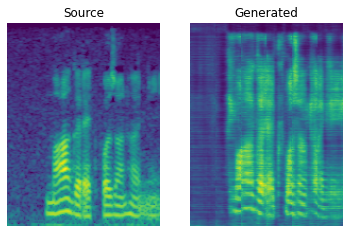

Mean D loss: 0.3013414144515991 Mean G loss: 0.8832805752754211 Mean ID loss: 0.22008199989795685
[Epoch 1/5000] [Batch 0] [D loss f: 0.3275147080421448 r: 0.30491602420806885] [G loss: 0.8102672100067139] [ID loss: 0.13614070415496826] [LR: 0.0002]
[Epoch 1/5000] [Batch 600] [D loss f: 0.3238939940929413 r: 0.31110987067222595] [G loss: 0.7915305495262146] [ID loss: 0.13452336192131042] [LR: 0.0002]
[Epoch 1/5000] [Batch 1200] [D loss f: 0.3191746473312378 r: 0.313216894865036] [G loss: 0.7650356292724609] [ID loss: 0.134468674659729] [LR: 0.0002]
[Epoch 1/5000] [Batch 1800] [D loss f: 0.32895132899284363 r: 0.32123300433158875] [G loss: 0.7839363813400269] [ID loss: 0.13233748078346252] [LR: 0.0002]
[Epoch 1/5000] [Batch 2400] [D loss f: 0.33443546295166016 r: 0.3322327435016632] [G loss: 0.7573816180229187] [ID loss: 0.1320231556892395] [LR: 0.0002]
[Epoch 1/5000] [Batch 3000] [D loss f: 0.33034130930900574 r: 0.3275846838951111] [G loss: 0.761379063129425] [ID loss: 0.1309788525104

  2%|▏         | 30/2000 [00:00<00:04, 440.93it/s, loss=0.000986, spectral_convergence=-4.9]

Saving...
(6, 192, 24, 1)


100%|██████████| 2000/2000 [00:03<00:00, 545.20it/s, loss=2.91e-5, spectral_convergence=-40.4]


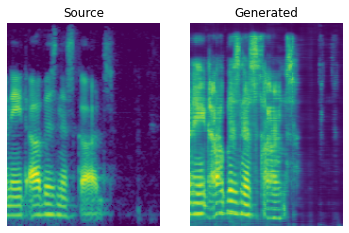

Mean D loss: 0.3854367434978485 Mean G loss: 0.6590137481689453 Mean ID loss: 0.12299048900604248
[Epoch 3/5000] [Batch 0] [D loss f: 0.3941850960254669 r: 0.3814309239387512] [G loss: 0.6633942127227783] [ID loss: 0.11940204352140427] [LR: 0.0002]
[Epoch 3/5000] [Batch 600] [D loss f: 0.39611735939979553 r: 0.38736870884895325] [G loss: 0.665939450263977] [ID loss: 0.11957267671823502] [LR: 0.0002]
[Epoch 3/5000] [Batch 1200] [D loss f: 0.39605414867401123 r: 0.38990727066993713] [G loss: 0.6320989727973938] [ID loss: 0.1192827895283699] [LR: 0.0002]
[Epoch 3/5000] [Batch 1800] [D loss f: 0.4027443826198578 r: 0.3856637477874756] [G loss: 0.6880294680595398] [ID loss: 0.1191333755850792] [LR: 0.0002]
[Epoch 3/5000] [Batch 2400] [D loss f: 0.4019697904586792 r: 0.3889317214488983] [G loss: 0.6604549884796143] [ID loss: 0.11945002526044846] [LR: 0.0002]
[Epoch 3/5000] [Batch 7800] [D loss f: 0.4025675058364868 r: 0.3888739347457886] [G loss: 0.6393890380859375] [ID loss: 0.1171333789825

  2%|▏         | 30/2000 [00:00<00:04, 442.63it/s, loss=0.0108, spectral_convergence=-1.11]

Saving...
(6, 192, 24, 1)


100%|██████████| 2000/2000 [00:03<00:00, 576.09it/s, loss=2.14e-5, spectral_convergence=-38.8]


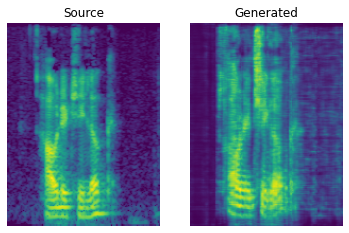

Mean D loss: 0.4165206849575043 Mean G loss: 0.6178150773048401 Mean ID loss: 0.11287306994199753
[Epoch 5/5000] [Batch 0] [D loss f: 0.418484091758728 r: 0.4014003872871399] [G loss: 0.6000978946685791] [ID loss: 0.11056757718324661] [LR: 0.0002]
[Epoch 5/5000] [Batch 600] [D loss f: 0.42216578125953674 r: 0.39329707622528076] [G loss: 0.6061059832572937] [ID loss: 0.11067149043083191] [LR: 0.0002]
[Epoch 5/5000] [Batch 1200] [D loss f: 0.4244512915611267 r: 0.3971194326877594] [G loss: 0.6386215686798096] [ID loss: 0.11068028956651688] [LR: 0.0002]
[Epoch 5/5000] [Batch 1800] [D loss f: 0.42470628023147583 r: 0.3985006809234619] [G loss: 0.6147872805595398] [ID loss: 0.11018481105566025] [LR: 0.0002]
[Epoch 5/5000] [Batch 2400] [D loss f: 0.416658490896225 r: 0.4015164077281952] [G loss: 0.5738551616668701] [ID loss: 0.11166540533304214] [LR: 0.0002]
[Epoch 5/5000] [Batch 3000] [D loss f: 0.42360419034957886 r: 0.4023377001285553] [G loss: 0.5694773197174072] [ID loss: 0.110278889536

  2%|▏         | 30/2000 [00:00<00:05, 393.05it/s, loss=0.000378, spectral_convergence=-7.94]

Saving...
(6, 192, 24, 1)


100%|██████████| 2000/2000 [00:03<00:00, 565.94it/s, loss=4.99e-5, spectral_convergence=-8.38]


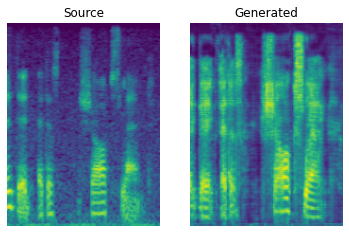

Mean D loss: 0.4243733286857605 Mean G loss: 0.6056163311004639 Mean ID loss: 0.10651474446058273
[Epoch 7/5000] [Batch 0] [D loss f: 0.4249649941921234 r: 0.39690491557121277] [G loss: 0.5812107920646667] [ID loss: 0.10545828193426132] [LR: 0.0002]
[Epoch 7/5000] [Batch 600] [D loss f: 0.41861939430236816 r: 0.3966732323169708] [G loss: 0.5804693698883057] [ID loss: 0.10586342960596085] [LR: 0.0002]
[Epoch 7/5000] [Batch 1200] [D loss f: 0.4276961386203766 r: 0.39558279514312744] [G loss: 0.6160855889320374] [ID loss: 0.10525956749916077] [LR: 0.0002]
[Epoch 7/5000] [Batch 1800] [D loss f: 0.4319694936275482 r: 0.3970410227775574] [G loss: 0.610461413860321] [ID loss: 0.10542081296443939] [LR: 0.0002]
[Epoch 7/5000] [Batch 2400] [D loss f: 0.4164450466632843 r: 0.3937641978263855] [G loss: 0.6083741188049316] [ID loss: 0.10578007251024246] [LR: 0.0002]
[Epoch 7/5000] [Batch 3000] [D loss f: 0.4231606721878052 r: 0.39471524953842163] [G loss: 0.6004113554954529] [ID loss: 0.10496349632

  2%|▏         | 30/2000 [00:00<00:04, 415.89it/s, loss=0.0061, spectral_convergence=-1.4]  

Saving...
(6, 192, 24, 1)


100%|██████████| 2000/2000 [00:03<00:00, 564.14it/s, loss=3.62e-5, spectral_convergence=-34.3]


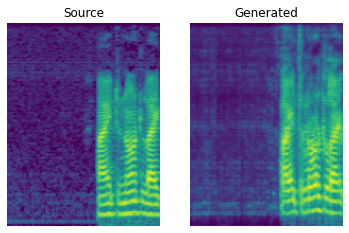

Mean D loss: 0.4159396290779114 Mean G loss: 0.6177121996879578 Mean ID loss: 0.10267186164855957
[Epoch 9/5000] [Batch 0] [D loss f: 0.41781163215637207 r: 0.38709142804145813] [G loss: 0.6353089809417725] [ID loss: 0.10122308135032654] [LR: 0.0002]
[Epoch 9/5000] [Batch 600] [D loss f: 0.41911181807518005 r: 0.3865962624549866] [G loss: 0.6533098816871643] [ID loss: 0.10131016373634338] [LR: 0.0002]
[Epoch 9/5000] [Batch 1200] [D loss f: 0.4077877700328827 r: 0.38395026326179504] [G loss: 0.6076117753982544] [ID loss: 0.10110129415988922] [LR: 0.0002]
[Epoch 9/5000] [Batch 1800] [D loss f: 0.416915625333786 r: 0.38693782687187195] [G loss: 0.6143474578857422] [ID loss: 0.10159234702587128] [LR: 0.0002]
[Epoch 9/5000] [Batch 2400] [D loss f: 0.41642579436302185 r: 0.38971564173698425] [G loss: 0.5904325246810913] [ID loss: 0.10150522738695145] [LR: 0.0002]
[Epoch 9/5000] [Batch 3000] [D loss f: 0.41594046354293823 r: 0.3849703073501587] [G loss: 0.5724176168441772] [ID loss: 0.1013337

  2%|▏         | 30/2000 [00:00<00:04, 436.32it/s, loss=0.000964, spectral_convergence=-4.72]

Saving...
(6, 192, 24, 1)


100%|██████████| 2000/2000 [00:03<00:00, 565.16it/s, loss=1.79e-5, spectral_convergence=-37]  


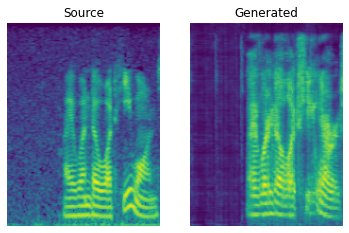

Mean D loss: 0.4074821472167969 Mean G loss: 0.6121018528938293 Mean ID loss: 0.09961598366498947
[Epoch 11/5000] [Batch 0] [D loss f: 0.4041425883769989 r: 0.38038167357444763] [G loss: 0.6414140462875366] [ID loss: 0.099469855427742] [LR: 0.0002]
[Epoch 11/5000] [Batch 600] [D loss f: 0.4047299325466156 r: 0.3832036852836609] [G loss: 0.6060873866081238] [ID loss: 0.09933802485466003] [LR: 0.0002]
[Epoch 11/5000] [Batch 1200] [D loss f: 0.40907007455825806 r: 0.3833363950252533] [G loss: 0.6067120432853699] [ID loss: 0.09872189909219742] [LR: 0.0002]
[Epoch 11/5000] [Batch 1800] [D loss f: 0.4097212255001068 r: 0.3806934654712677] [G loss: 0.6394724249839783] [ID loss: 0.09927111864089966] [LR: 0.0002]
[Epoch 11/5000] [Batch 2400] [D loss f: 0.4107557237148285 r: 0.38271912932395935] [G loss: 0.6268044114112854] [ID loss: 0.09931156039237976] [LR: 0.0002]
[Epoch 11/5000] [Batch 3000] [D loss f: 0.41067609190940857 r: 0.3806817829608917] [G loss: 0.595460832118988] [ID loss: 0.0990304

  1%|          | 20/2000 [00:00<00:05, 330.14it/s, loss=0.00225, spectral_convergence=-1.23]

Saving...
(6, 192, 24, 1)


100%|██████████| 2000/2000 [00:03<00:00, 532.80it/s, loss=2.51e-5, spectral_convergence=-38.5]


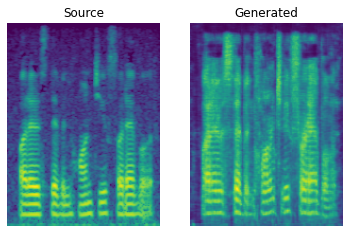

Mean D loss: 0.4014100730419159 Mean G loss: 0.6160494089126587 Mean ID loss: 0.09771045297384262
[Epoch 13/5000] [Batch 0] [D loss f: 0.4003296196460724 r: 0.38403835892677307] [G loss: 0.6026709079742432] [ID loss: 0.09692469239234924] [LR: 0.0002]
[Epoch 13/5000] [Batch 600] [D loss f: 0.40335074067115784 r: 0.38132762908935547] [G loss: 0.6188111305236816] [ID loss: 0.09740255028009415] [LR: 0.0002]
[Epoch 13/5000] [Batch 1200] [D loss f: 0.40252381563186646 r: 0.38329774141311646] [G loss: 0.5915865898132324] [ID loss: 0.0979924350976944] [LR: 0.0002]
[Epoch 13/5000] [Batch 1800] [D loss f: 0.40408939123153687 r: 0.384151816368103] [G loss: 0.6042041778564453] [ID loss: 0.09726135432720184] [LR: 0.0002]
[Epoch 13/5000] [Batch 2400] [D loss f: 0.4022853970527649 r: 0.38092687726020813] [G loss: 0.6253100633621216] [ID loss: 0.09739825129508972] [LR: 0.0002]
[Epoch 13/5000] [Batch 3000] [D loss f: 0.39913007616996765 r: 0.38266560435295105] [G loss: 0.625157356262207] [ID loss: 0.09

  1%|          | 20/2000 [00:00<00:06, 308.93it/s, loss=0.00166, spectral_convergence=-2.27]

Saving...
(6, 192, 24, 1)


100%|██████████| 2000/2000 [00:03<00:00, 553.48it/s, loss=2.12e-5, spectral_convergence=-43.4]


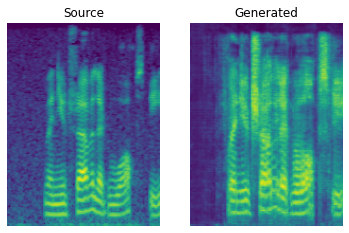

Mean D loss: 0.40090563893318176 Mean G loss: 0.6174785494804382 Mean ID loss: 0.09602899849414825
[Epoch 15/5000] [Batch 0] [D loss f: 0.4015549123287201 r: 0.38620713353157043] [G loss: 0.6076772809028625] [ID loss: 0.09563633054494858] [LR: 0.0002]
[Epoch 15/5000] [Batch 600] [D loss f: 0.3990750014781952 r: 0.38998550176620483] [G loss: 0.6183505654335022] [ID loss: 0.09580342471599579] [LR: 0.0002]
[Epoch 15/5000] [Batch 1200] [D loss f: 0.39783233404159546 r: 0.3844817578792572] [G loss: 0.6137667894363403] [ID loss: 0.09572704136371613] [LR: 0.0002]
[Epoch 15/5000] [Batch 1800] [D loss f: 0.3974342942237854 r: 0.3862103223800659] [G loss: 0.5870997905731201] [ID loss: 0.09589498490095139] [LR: 0.0002]
[Epoch 15/5000] [Batch 2400] [D loss f: 0.4005604684352875 r: 0.387039452791214] [G loss: 0.5975128412246704] [ID loss: 0.09558380395174026] [LR: 0.0002]
[Epoch 15/5000] [Batch 3000] [D loss f: 0.4025025963783264 r: 0.38543131947517395] [G loss: 0.5982168316841125] [ID loss: 0.0953

  1%|          | 20/2000 [00:00<00:05, 332.41it/s, loss=0.00664, spectral_convergence=-.954]

Saving...
(6, 192, 24, 1)


100%|██████████| 2000/2000 [00:03<00:00, 526.33it/s, loss=4e-5, spectral_convergence=-36]     


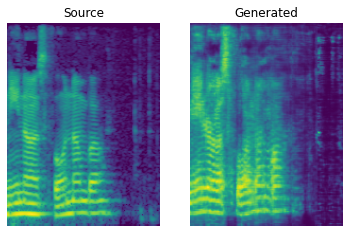

Mean D loss: 0.39762476086616516 Mean G loss: 0.6205219030380249 Mean ID loss: 0.09446314722299576
[Epoch 17/5000] [Batch 0] [D loss f: 0.3953385651111603 r: 0.38796553015708923] [G loss: 0.6166271567344666] [ID loss: 0.09451353549957275] [LR: 0.0002]
[Epoch 17/5000] [Batch 600] [D loss f: 0.4000949263572693 r: 0.3894648849964142] [G loss: 0.6375638842582703] [ID loss: 0.09398506581783295] [LR: 0.0002]
[Epoch 17/5000] [Batch 1200] [D loss f: 0.3946824371814728 r: 0.38508784770965576] [G loss: 0.6455166935920715] [ID loss: 0.09433820098638535] [LR: 0.0002]
[Epoch 17/5000] [Batch 1800] [D loss f: 0.3946323096752167 r: 0.38349711894989014] [G loss: 0.6150129437446594] [ID loss: 0.09432857483625412] [LR: 0.0002]
[Epoch 17/5000] [Batch 2400] [D loss f: 0.39483392238616943 r: 0.38703250885009766] [G loss: 0.6513481736183167] [ID loss: 0.09419768303632736] [LR: 0.0002]
[Epoch 17/5000] [Batch 3000] [D loss f: 0.3968468904495239 r: 0.3922802209854126] [G loss: 0.60894775390625] [ID loss: 0.0939

  2%|▏         | 30/2000 [00:00<00:05, 389.50it/s, loss=0.00199, spectral_convergence=-3.12]

Saving...
(6, 192, 24, 1)


100%|██████████| 2000/2000 [00:03<00:00, 535.44it/s, loss=0.000103, spectral_convergence=-31.4]


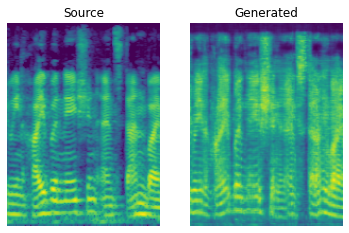

Mean D loss: 0.39432331919670105 Mean G loss: 0.6184415817260742 Mean ID loss: 0.09332142770290375
[Epoch 19/5000] [Batch 0] [D loss f: 0.3925240933895111 r: 0.3922925889492035] [G loss: 0.6381363272666931] [ID loss: 0.09334369003772736] [LR: 0.0002]
[Epoch 19/5000] [Batch 600] [D loss f: 0.3920009434223175 r: 0.39346835017204285] [G loss: 0.6054327487945557] [ID loss: 0.0933210477232933] [LR: 0.0002]
[Epoch 19/5000] [Batch 1200] [D loss f: 0.3928147852420807 r: 0.3926613926887512] [G loss: 0.6015907526016235] [ID loss: 0.09303342550992966] [LR: 0.0002]
[Epoch 19/5000] [Batch 1800] [D loss f: 0.3940565884113312 r: 0.38465622067451477] [G loss: 0.6367327570915222] [ID loss: 0.09298507124185562] [LR: 0.0002]
[Epoch 19/5000] [Batch 2400] [D loss f: 0.3971201181411743 r: 0.3902166187763214] [G loss: 0.6048208475112915] [ID loss: 0.0933631956577301] [LR: 0.0002]
[Epoch 19/5000] [Batch 3000] [D loss f: 0.3914856016635895 r: 0.3928735852241516] [G loss: 0.6113300323486328] [ID loss: 0.0928624

  2%|▏         | 30/2000 [00:00<00:04, 404.42it/s, loss=0.00145, spectral_convergence=-2.72]

Saving...
(6, 192, 24, 1)


 84%|████████▍ | 1690/2000 [00:03<00:00, 555.96it/s, loss=0.000463, spectral_convergence=-13.3]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[Epoch 24/5000] [Batch 4800] [D loss f: 0.39365723729133606 r: 0.3952024281024933] [G loss: 0.6070130467414856] [ID loss: 0.09077412635087967] [LR: 0.0002]
[Epoch 24/5000] [Batch 9600] [D loss f: 0.39001545310020447 r: 0.400533527135849] [G loss: 0.5908867716789246] [ID loss: 0.09075278043746948] [LR: 0.0002]
[Epoch 24/5000] [Batch 10200] [D loss f: 0.38563212752342224 r: 0.39684823155403137] [G loss: 0.6269749999046326] [ID loss: 0.09042490273714066] [LR: 0.0002]
[Epoch 24/5000] [Batch 10800] [D loss f: 0.3897005021572113 r: 0.397560715675354] [G loss: 0.6189656853675842] [ID loss: 0.09078826755285263] [LR: 0.0002]
[Epoch 24/5000] [Batch 11400] [D loss f: 0.3865926265716553 r: 0.4005826711654663] [G loss: 0.6330200433731079] [ID loss: 0.09131890535354614] [LR: 0.0002]
[Epoch 24/5000] [Batch 12000] [D loss f: 0.3857358396053314 r: 0.39805734157562256] [G loss: 0.6206545233726501] [ID loss: 0.09053206443786621] [LR: 0.0002]
[Epoch 24/5000] [Batch 12600] [D loss f: 0.38923731446266174 r:

  2%|▏         | 30/2000 [00:00<00:04, 437.03it/s, loss=0.000826, spectral_convergence=-5.73]

Saving...
(6, 192, 24, 1)


100%|██████████| 2000/2000 [00:03<00:00, 560.48it/s, loss=1.42e-5, spectral_convergence=-36.7]


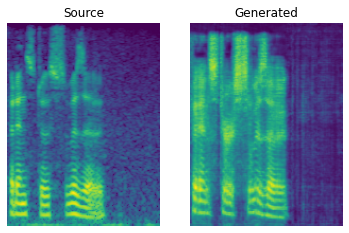

Mean D loss: 0.3885595500469208 Mean G loss: 0.6243282556533813 Mean ID loss: 0.09083487838506699
[Epoch 25/5000] [Batch 0] [D loss f: 0.38982483744621277 r: 0.4013027548789978] [G loss: 0.6064527034759521] [ID loss: 0.09026604145765305] [LR: 0.0002]
[Epoch 25/5000] [Batch 600] [D loss f: 0.387819766998291 r: 0.3956192433834076] [G loss: 0.6113200783729553] [ID loss: 0.09095947444438934] [LR: 0.0002]
[Epoch 25/5000] [Batch 1200] [D loss f: 0.38643622398376465 r: 0.40182220935821533] [G loss: 0.6453554034233093] [ID loss: 0.09073246270418167] [LR: 0.0002]
[Epoch 25/5000] [Batch 1800] [D loss f: 0.388119101524353 r: 0.39413052797317505] [G loss: 0.6180309057235718] [ID loss: 0.09043331444263458] [LR: 0.0002]
[Epoch 25/5000] [Batch 2400] [D loss f: 0.38888880610466003 r: 0.3955448865890503] [G loss: 0.644483208656311] [ID loss: 0.09075623005628586] [LR: 0.0002]
[Epoch 25/5000] [Batch 3000] [D loss f: 0.383518248796463 r: 0.3942224383354187] [G loss: 0.6327336430549622] [ID loss: 0.0909633

  2%|▏         | 30/2000 [00:00<00:04, 409.40it/s, loss=0.00153, spectral_convergence=-3.34]

Saving...
(6, 192, 24, 1)


100%|██████████| 2000/2000 [00:03<00:00, 537.36it/s, loss=8.28e-5, spectral_convergence=-28.8] 


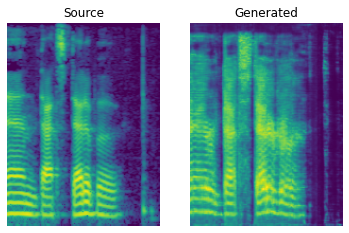

Mean D loss: 0.3864331841468811 Mean G loss: 0.6169584393501282 Mean ID loss: 0.09029893577098846
[Epoch 27/5000] [Batch 0] [D loss f: 0.3857060968875885 r: 0.40490710735321045] [G loss: 0.6422104835510254] [ID loss: 0.08967090398073196] [LR: 0.0002]
[Epoch 27/5000] [Batch 600] [D loss f: 0.3885939419269562 r: 0.4008359909057617] [G loss: 0.6308175921440125] [ID loss: 0.08950571715831757] [LR: 0.0002]
[Epoch 27/5000] [Batch 1200] [D loss f: 0.38207560777664185 r: 0.39909476041793823] [G loss: 0.6024808883666992] [ID loss: 0.09054341912269592] [LR: 0.0002]
[Epoch 27/5000] [Batch 1800] [D loss f: 0.38845399022102356 r: 0.3920474350452423] [G loss: 0.6203067302703857] [ID loss: 0.09007658809423447] [LR: 0.0002]
[Epoch 27/5000] [Batch 2400] [D loss f: 0.37848684191703796 r: 0.3996469974517822] [G loss: 0.6131708025932312] [ID loss: 0.09076602011919022] [LR: 0.0002]
[Epoch 27/5000] [Batch 3000] [D loss f: 0.3850320875644684 r: 0.39864206314086914] [G loss: 0.6341355443000793] [ID loss: 0.09

  2%|▏         | 30/2000 [00:00<00:04, 434.31it/s, loss=0.000374, spectral_convergence=-6.54]

Saving...
(6, 192, 24, 1)


100%|██████████| 2000/2000 [00:03<00:00, 525.67it/s, loss=5.72e-6, spectral_convergence=-35.5]


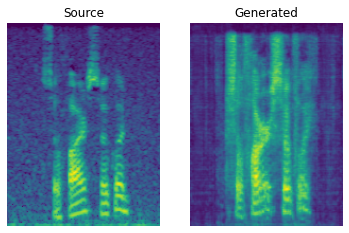

Mean D loss: 0.385627806186676 Mean G loss: 0.6239681839942932 Mean ID loss: 0.08968538045883179
[Epoch 29/5000] [Batch 0] [D loss f: 0.38651517033576965 r: 0.40099087357521057] [G loss: 0.6452609300613403] [ID loss: 0.08943513035774231] [LR: 0.0002]
[Epoch 29/5000] [Batch 600] [D loss f: 0.38416412472724915 r: 0.39783594012260437] [G loss: 0.6349565386772156] [ID loss: 0.0891234427690506] [LR: 0.0002]
[Epoch 29/5000] [Batch 1200] [D loss f: 0.3851679861545563 r: 0.405033677816391] [G loss: 0.5877342224121094] [ID loss: 0.08975590020418167] [LR: 0.0002]
[Epoch 29/5000] [Batch 1800] [D loss f: 0.3447542190551758 r: 0.36078229546546936] [G loss: 0.6928078532218933] [ID loss: 0.0917319729924202] [LR: 0.0002]
[Epoch 29/5000] [Batch 2400] [D loss f: 0.3859426975250244 r: 0.3871282935142517] [G loss: 0.6372298002243042] [ID loss: 0.08950556069612503] [LR: 0.0002]
[Epoch 29/5000] [Batch 3000] [D loss f: 0.3809463083744049 r: 0.4012954831123352] [G loss: 0.6159707903862] [ID loss: 0.0892036631

  2%|▏         | 30/2000 [00:00<00:04, 419.21it/s, loss=0.000533, spectral_convergence=-5.07]

Saving...
(6, 192, 24, 1)


100%|██████████| 2000/2000 [00:03<00:00, 529.65it/s, loss=5.27e-5, spectral_convergence=-32]  


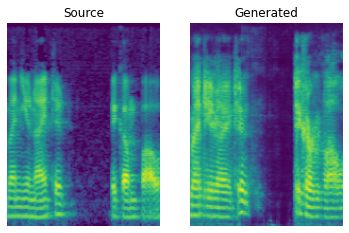

Mean D loss: 0.3839782774448395 Mean G loss: 0.6311160326004028 Mean ID loss: 0.08904244750738144
[Epoch 31/5000] [Batch 0] [D loss f: 0.38729798793792725 r: 0.4050435423851013] [G loss: 0.6347782015800476] [ID loss: 0.08915609866380692] [LR: 0.0002]
[Epoch 31/5000] [Batch 600] [D loss f: 0.374083936214447 r: 0.39183592796325684] [G loss: 0.6387178301811218] [ID loss: 0.0900876522064209] [LR: 0.0002]
[Epoch 31/5000] [Batch 1200] [D loss f: 0.38345128297805786 r: 0.4060817062854767] [G loss: 0.6110532879829407] [ID loss: 0.08912942558526993] [LR: 0.0002]
[Epoch 31/5000] [Batch 1800] [D loss f: 0.38102129101753235 r: 0.4105914831161499] [G loss: 0.6137835383415222] [ID loss: 0.08880387991666794] [LR: 0.0002]
[Epoch 31/5000] [Batch 2400] [D loss f: 0.38411247730255127 r: 0.40660786628723145] [G loss: 0.6345066428184509] [ID loss: 0.0888906717300415] [LR: 0.0002]
[Epoch 31/5000] [Batch 3000] [D loss f: 0.38462933897972107 r: 0.40511205792427063] [G loss: 0.6238017678260803] [ID loss: 0.089

  2%|▏         | 30/2000 [00:00<00:05, 391.63it/s, loss=0.000711, spectral_convergence=-6.53]

Saving...
(6, 192, 24, 1)


100%|██████████| 2000/2000 [00:03<00:00, 547.38it/s, loss=3.88e-5, spectral_convergence=-45]  


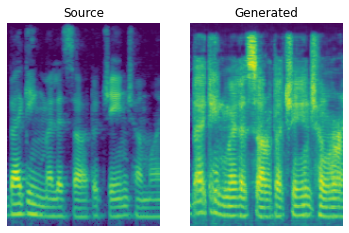

Mean D loss: 0.38186144828796387 Mean G loss: 0.6238664388656616 Mean ID loss: 0.08861564844846725
[Epoch 33/5000] [Batch 0] [D loss f: 0.380947083234787 r: 0.40514329075813293] [G loss: 0.6193197965621948] [ID loss: 0.08840710669755936] [LR: 0.0002]
[Epoch 33/5000] [Batch 600] [D loss f: 0.38009339570999146 r: 0.4111883044242859] [G loss: 0.6269513368606567] [ID loss: 0.08846472948789597] [LR: 0.0002]
[Epoch 33/5000] [Batch 1200] [D loss f: 0.3798608183860779 r: 0.4069133400917053] [G loss: 0.6148983836174011] [ID loss: 0.08854106068611145] [LR: 0.0002]
[Epoch 33/5000] [Batch 1800] [D loss f: 0.38558050990104675 r: 0.4096543788909912] [G loss: 0.6458112001419067] [ID loss: 0.0883156806230545] [LR: 0.0002]
[Epoch 33/5000] [Batch 2400] [D loss f: 0.3807818591594696 r: 0.4058074355125427] [G loss: 0.6403909921646118] [ID loss: 0.0886445865035057] [LR: 0.0002]
[Epoch 33/5000] [Batch 3000] [D loss f: 0.3844430148601532 r: 0.40577593445777893] [G loss: 0.5838887691497803] [ID loss: 0.088405

  1%|          | 20/2000 [00:00<00:05, 332.06it/s, loss=0.00071, spectral_convergence=-3.66]

Saving...
(6, 192, 24, 1)


 86%|████████▌ | 1720/2000 [00:03<00:00, 545.50it/s, loss=0.000243, spectral_convergence=-13.3]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[Epoch 38/5000] [Batch 7800] [D loss f: 0.37728801369667053 r: 0.4114297032356262] [G loss: 0.6106842160224915] [ID loss: 0.08716137707233429] [LR: 0.0002]
[Epoch 38/5000] [Batch 12600] [D loss f: 0.3777153491973877 r: 0.4089713990688324] [G loss: 0.6451837420463562] [ID loss: 0.08737041801214218] [LR: 0.0002]
[Epoch 38/5000] [Batch 13200] [D loss f: 0.37564390897750854 r: 0.41030022501945496] [G loss: 0.6277490258216858] [ID loss: 0.08725740015506744] [LR: 0.0002]
Completed epoch 38/5000 /t Time/Batch 0.0359803531839286


  2%|▏         | 30/2000 [00:00<00:05, 389.64it/s, loss=0.000764, spectral_convergence=-2.11]

Saving...
(6, 192, 24, 1)


100%|██████████| 2000/2000 [00:03<00:00, 527.39it/s, loss=1.44e-5, spectral_convergence=-31.7]


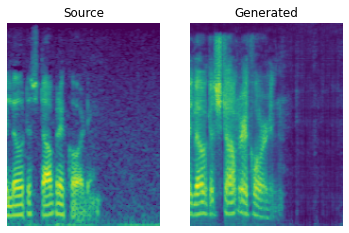

Mean D loss: 0.3760940134525299 Mean G loss: 0.6284862756729126 Mean ID loss: 0.08738655596971512
[Epoch 39/5000] [Batch 0] [D loss f: 0.3711484968662262 r: 0.4199289381504059] [G loss: 0.6103933453559875] [ID loss: 0.08799764513969421] [LR: 0.0002]
[Epoch 39/5000] [Batch 600] [D loss f: 0.3749891519546509 r: 0.4168824851512909] [G loss: 0.6473387479782104] [ID loss: 0.0870257169008255] [LR: 0.0002]
[Epoch 39/5000] [Batch 1200] [D loss f: 0.3761817514896393 r: 0.4106022119522095] [G loss: 0.6328555345535278] [ID loss: 0.08731231093406677] [LR: 0.0002]
[Epoch 39/5000] [Batch 1800] [D loss f: 0.37174326181411743 r: 0.4103611707687378] [G loss: 0.6142178177833557] [ID loss: 0.08781969547271729] [LR: 0.0002]
[Epoch 39/5000] [Batch 2400] [D loss f: 0.3756062090396881 r: 0.4150802195072174] [G loss: 0.6158968806266785] [ID loss: 0.08731422573328018] [LR: 0.0002]
[Epoch 39/5000] [Batch 3000] [D loss f: 0.374728798866272 r: 0.418415367603302] [G loss: 0.6302440166473389] [ID loss: 0.0873979032

  1%|          | 20/2000 [00:00<00:06, 300.55it/s, loss=0.001, spectral_convergence=-2.75] 

Saving...
(6, 192, 24, 1)


100%|██████████| 2000/2000 [00:03<00:00, 531.76it/s, loss=5.17e-5, spectral_convergence=-44.6]


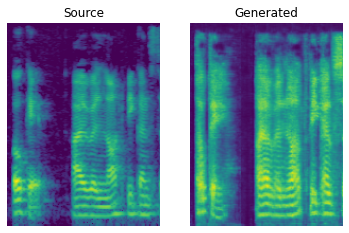

Mean D loss: 0.37566328048706055 Mean G loss: 0.6379407048225403 Mean ID loss: 0.08723712712526321
[Epoch 41/5000] [Batch 0] [D loss f: 0.3798638582229614 r: 0.4074046313762665] [G loss: 0.6292393803596497] [ID loss: 0.08709951490163803] [LR: 0.0002]
[Epoch 41/5000] [Batch 600] [D loss f: 0.38131722807884216 r: 0.4150006175041199] [G loss: 0.6496080160140991] [ID loss: 0.08702816069126129] [LR: 0.0002]
[Epoch 41/5000] [Batch 1200] [D loss f: 0.36827296018600464 r: 0.42144349217414856] [G loss: 0.6570407748222351] [ID loss: 0.08690467476844788] [LR: 0.0002]
[Epoch 41/5000] [Batch 1800] [D loss f: 0.3709150552749634 r: 0.4166061282157898] [G loss: 0.641433596611023] [ID loss: 0.08720876276493073] [LR: 0.0002]
[Epoch 41/5000] [Batch 2400] [D loss f: 0.3740614354610443 r: 0.4127693176269531] [G loss: 0.6428016424179077] [ID loss: 0.08667389303445816] [LR: 0.0002]
[Epoch 41/5000] [Batch 3000] [D loss f: 0.37272271513938904 r: 0.41774648427963257] [G loss: 0.6367623209953308] [ID loss: 0.087

  1%|          | 20/2000 [00:00<00:06, 327.98it/s, loss=0.0017, spectral_convergence=-1.78]

Saving...
(6, 192, 24, 1)


100%|██████████| 2000/2000 [00:03<00:00, 533.91it/s, loss=1.61e-5, spectral_convergence=-41.5]


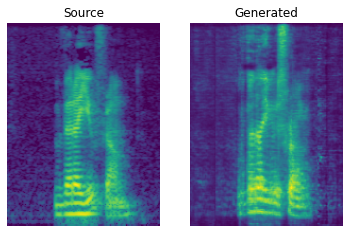

Mean D loss: 0.3732033967971802 Mean G loss: 0.6315926909446716 Mean ID loss: 0.08684875071048737
[Epoch 43/5000] [Batch 0] [D loss f: 0.3709307610988617 r: 0.4100574553012848] [G loss: 0.6372475028038025] [ID loss: 0.08723697811365128] [LR: 0.0002]
[Epoch 43/5000] [Batch 600] [D loss f: 0.37617066502571106 r: 0.41591277718544006] [G loss: 0.6162252426147461] [ID loss: 0.08631983399391174] [LR: 0.0002]
[Epoch 43/5000] [Batch 1200] [D loss f: 0.37147438526153564 r: 0.4149705469608307] [G loss: 0.6237707138061523] [ID loss: 0.08659441769123077] [LR: 0.0002]
[Epoch 43/5000] [Batch 1800] [D loss f: 0.3722599744796753 r: 0.4186880588531494] [G loss: 0.6602056622505188] [ID loss: 0.0864928811788559] [LR: 0.0002]
[Epoch 43/5000] [Batch 2400] [D loss f: 0.3802085220813751 r: 0.4087728261947632] [G loss: 0.640471875667572] [ID loss: 0.08676700294017792] [LR: 0.0002]
[Epoch 43/5000] [Batch 3000] [D loss f: 0.3694007694721222 r: 0.4164881706237793] [G loss: 0.6373499631881714] [ID loss: 0.0868821

  1%|          | 20/2000 [00:00<00:05, 336.46it/s, loss=0.000819, spectral_convergence=-4.49]

Saving...
(6, 192, 24, 1)


100%|██████████| 2000/2000 [00:03<00:00, 542.69it/s, loss=8.82e-5, spectral_convergence=-35]   


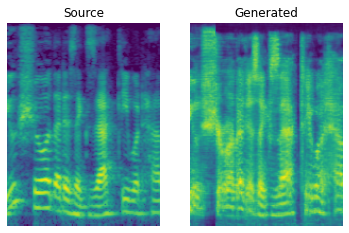

Mean D loss: 0.3721664845943451 Mean G loss: 0.6314473152160645 Mean ID loss: 0.08660151809453964
[Epoch 45/5000] [Batch 0] [D loss f: 0.36964869499206543 r: 0.4217348098754883] [G loss: 0.6572197079658508] [ID loss: 0.08678165823221207] [LR: 0.0002]
[Epoch 45/5000] [Batch 600] [D loss f: 0.3740555942058563 r: 0.4157281517982483] [G loss: 0.6500294804573059] [ID loss: 0.08672156184911728] [LR: 0.0002]
[Epoch 45/5000] [Batch 1200] [D loss f: 0.3740951120853424 r: 0.41941186785697937] [G loss: 0.6249303221702576] [ID loss: 0.08645188808441162] [LR: 0.0002]
[Epoch 45/5000] [Batch 1800] [D loss f: 0.37181544303894043 r: 0.41617873311042786] [G loss: 0.6452777981758118] [ID loss: 0.0866703987121582] [LR: 0.0002]
[Epoch 45/5000] [Batch 2400] [D loss f: 0.378724604845047 r: 0.41044872999191284] [G loss: 0.6244682669639587] [ID loss: 0.08686677366495132] [LR: 0.0002]
[Epoch 45/5000] [Batch 3000] [D loss f: 0.37370580434799194 r: 0.42185407876968384] [G loss: 0.6167750954627991] [ID loss: 0.086

  2%|▏         | 30/2000 [00:00<00:04, 416.74it/s, loss=0.000233, spectral_convergence=-7.94]

Saving...
(6, 192, 24, 1)


100%|██████████| 2000/2000 [00:03<00:00, 550.02it/s, loss=8.2e-6, spectral_convergence=-35.9] 


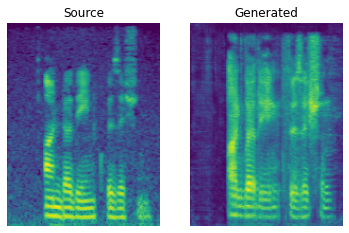

Mean D loss: 0.3712429106235504 Mean G loss: 0.6433006525039673 Mean ID loss: 0.08634142577648163
[Epoch 47/5000] [Batch 0] [D loss f: 0.37098944187164307 r: 0.4256611466407776] [G loss: 0.6434396505355835] [ID loss: 0.08632393926382065] [LR: 0.0002]
[Epoch 47/5000] [Batch 600] [D loss f: 0.3713739812374115 r: 0.42204752564430237] [G loss: 0.6308839917182922] [ID loss: 0.08603276312351227] [LR: 0.0002]
[Epoch 47/5000] [Batch 1200] [D loss f: 0.37237197160720825 r: 0.41937264800071716] [G loss: 0.6470373272895813] [ID loss: 0.086232990026474] [LR: 0.0002]
[Epoch 47/5000] [Batch 1800] [D loss f: 0.3564629554748535 r: 0.4017316699028015] [G loss: 0.652254581451416] [ID loss: 0.08676479011774063] [LR: 0.0002]
[Epoch 47/5000] [Batch 2400] [D loss f: 0.3703192174434662 r: 0.42102327942848206] [G loss: 0.6735802292823792] [ID loss: 0.0861327052116394] [LR: 0.0002]
[Epoch 47/5000] [Batch 3000] [D loss f: 0.36927324533462524 r: 0.42341139912605286] [G loss: 0.6384668350219727] [ID loss: 0.08652

  1%|          | 20/2000 [00:00<00:05, 359.39it/s, loss=0.000965, spectral_convergence=-4.4]

Saving...
(6, 192, 24, 1)


 80%|████████  | 1610/2000 [00:03<00:00, 512.57it/s, loss=0.000323, spectral_convergence=-12.9]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[Epoch 52/5000] [Batch 10200] [D loss f: 0.37019112706184387 r: 0.42349234223365784] [G loss: 0.6575648784637451] [ID loss: 0.08550910651683807] [LR: 0.0002]
[Epoch 53/5000] [Batch 600] [D loss f: 0.3677809536457062 r: 0.4260232150554657] [G loss: 0.6673800945281982] [ID loss: 0.08570395410060883] [LR: 0.0002]
[Epoch 53/5000] [Batch 1200] [D loss f: 0.36528584361076355 r: 0.4274546205997467] [G loss: 0.6256741881370544] [ID loss: 0.08555074781179428] [LR: 0.0002]
[Epoch 53/5000] [Batch 1800] [D loss f: 0.3691710829734802 r: 0.42482247948646545] [G loss: 0.6803656220436096] [ID loss: 0.08607255667448044] [LR: 0.0002]
[Epoch 53/5000] [Batch 2400] [D loss f: 0.3686176538467407 r: 0.42529451847076416] [G loss: 0.6477614641189575] [ID loss: 0.08560545742511749] [LR: 0.0002]
[Epoch 53/5000] [Batch 3000] [D loss f: 0.37004539370536804 r: 0.4233913719654083] [G loss: 0.6452847123146057] [ID loss: 0.08572567999362946] [LR: 0.0002]
[Epoch 53/5000] [Batch 3600] [D loss f: 0.36387792229652405 r: 0

  1%|          | 20/2000 [00:00<00:05, 334.31it/s, loss=0.00194, spectral_convergence=-1.43]

Saving...
(6, 192, 24, 1)


100%|██████████| 2000/2000 [00:03<00:00, 525.24it/s, loss=3.85e-5, spectral_convergence=-35.2]


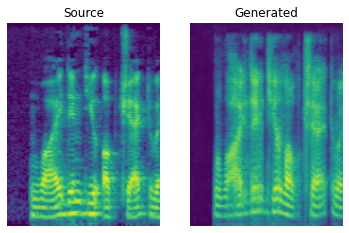

Mean D loss: 0.36597293615341187 Mean G loss: 0.6378538012504578 Mean ID loss: 0.08543549478054047
[Epoch 55/5000] [Batch 0] [D loss f: 0.3690633773803711 r: 0.4284643530845642] [G loss: 0.6407806873321533] [ID loss: 0.08558308333158493] [LR: 0.0002]
[Epoch 55/5000] [Batch 600] [D loss f: 0.36386916041374207 r: 0.43169790506362915] [G loss: 0.6450482606887817] [ID loss: 0.08571808785200119] [LR: 0.0002]
[Epoch 55/5000] [Batch 1200] [D loss f: 0.357217013835907 r: 0.42861878871917725] [G loss: 0.6532776951789856] [ID loss: 0.08523375540971756] [LR: 0.0002]
[Epoch 55/5000] [Batch 1800] [D loss f: 0.3636660873889923 r: 0.42583146691322327] [G loss: 0.6501964926719666] [ID loss: 0.08522572368383408] [LR: 0.0002]
[Epoch 55/5000] [Batch 2400] [D loss f: 0.36794063448905945 r: 0.4255046248435974] [G loss: 0.6691976189613342] [ID loss: 0.08484845608472824] [LR: 0.0002]
[Epoch 55/5000] [Batch 3000] [D loss f: 0.3644882142543793 r: 0.43115121126174927] [G loss: 0.6595374345779419] [ID loss: 0.08

  1%|          | 20/2000 [00:00<00:05, 345.58it/s, loss=0.00117, spectral_convergence=-2.48]

Saving...
(6, 192, 24, 1)


100%|██████████| 2000/2000 [00:03<00:00, 535.51it/s, loss=5.09e-5, spectral_convergence=-47.1]


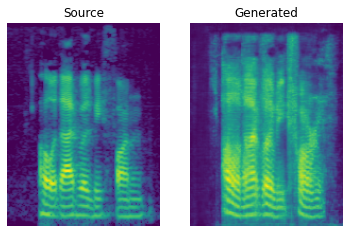

Mean D loss: 0.3595655858516693 Mean G loss: 0.6599768996238708 Mean ID loss: 0.08541850000619888
[Epoch 57/5000] [Batch 0] [D loss f: 0.3661119341850281 r: 0.42927902936935425] [G loss: 0.6668123602867126] [ID loss: 0.08539337664842606] [LR: 0.0002]
[Epoch 57/5000] [Batch 600] [D loss f: 0.363343745470047 r: 0.4318505823612213] [G loss: 0.6816014647483826] [ID loss: 0.08529184758663177] [LR: 0.0002]
[Epoch 57/5000] [Batch 1200] [D loss f: 0.3658981919288635 r: 0.4297451674938202] [G loss: 0.6240469813346863] [ID loss: 0.08531671017408371] [LR: 0.0002]
[Epoch 57/5000] [Batch 1800] [D loss f: 0.36470505595207214 r: 0.4322413206100464] [G loss: 0.6397027373313904] [ID loss: 0.08523145318031311] [LR: 0.0002]
[Epoch 57/5000] [Batch 2400] [D loss f: 0.3613381087779999 r: 0.42759227752685547] [G loss: 0.6625261902809143] [ID loss: 0.08508726954460144] [LR: 0.0002]
[Epoch 57/5000] [Batch 3000] [D loss f: 0.3565181791782379 r: 0.42704787850379944] [G loss: 0.6493045687675476] [ID loss: 0.08560

  2%|▏         | 30/2000 [00:00<00:04, 411.61it/s, loss=0.000194, spectral_convergence=-7.64]

Saving...
(6, 192, 24, 1)


100%|██████████| 2000/2000 [00:03<00:00, 535.49it/s, loss=7.73e-6, spectral_convergence=-36]  


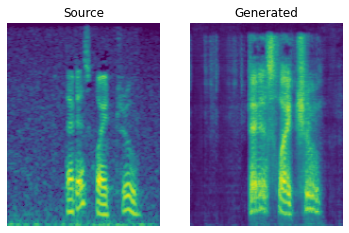

Mean D loss: 0.36037495732307434 Mean G loss: 0.6430212259292603 Mean ID loss: 0.0851072147488594
[Epoch 59/5000] [Batch 0] [D loss f: 0.354962557554245 r: 0.4267672300338745] [G loss: 0.6808195114135742] [ID loss: 0.08499427139759064] [LR: 0.0002]
[Epoch 59/5000] [Batch 600] [D loss f: 0.36390072107315063 r: 0.43208542466163635] [G loss: 0.6376650929450989] [ID loss: 0.08506880700588226] [LR: 0.0002]
[Epoch 59/5000] [Batch 1200] [D loss f: 0.35625335574150085 r: 0.4346131384372711] [G loss: 0.6819063425064087] [ID loss: 0.0848812609910965] [LR: 0.0002]
[Epoch 59/5000] [Batch 1800] [D loss f: 0.3670042157173157 r: 0.43259724974632263] [G loss: 0.6056115031242371] [ID loss: 0.08459534496068954] [LR: 0.0002]
[Epoch 59/5000] [Batch 2400] [D loss f: 0.35826462507247925 r: 0.43418049812316895] [G loss: 0.6647619605064392] [ID loss: 0.08510817587375641] [LR: 0.0002]
[Epoch 59/5000] [Batch 3000] [D loss f: 0.3635341227054596 r: 0.428941547870636] [G loss: 0.6467124819755554] [ID loss: 0.08493

  1%|          | 20/2000 [00:00<00:05, 345.30it/s, loss=0.000585, spectral_convergence=-1.78]

Saving...
(6, 192, 24, 1)


100%|██████████| 2000/2000 [00:03<00:00, 525.28it/s, loss=2.73e-5, spectral_convergence=-31.3]


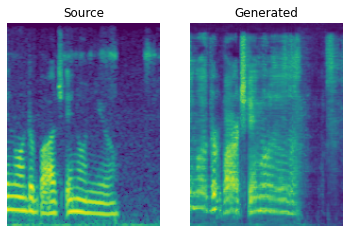

Mean D loss: 0.35588565468788147 Mean G loss: 0.6620078682899475 Mean ID loss: 0.0851634070277214
[Epoch 61/5000] [Batch 0] [D loss f: 0.35738661885261536 r: 0.43253085017204285] [G loss: 0.6575146317481995] [ID loss: 0.08453627675771713] [LR: 0.0002]
[Epoch 61/5000] [Batch 600] [D loss f: 0.3613298833370209 r: 0.423453152179718] [G loss: 0.6845930218696594] [ID loss: 0.08459769934415817] [LR: 0.0002]
[Epoch 61/5000] [Batch 1200] [D loss f: 0.36187291145324707 r: 0.42877256870269775] [G loss: 0.6527677178382874] [ID loss: 0.08477658033370972] [LR: 0.0002]
[Epoch 61/5000] [Batch 1800] [D loss f: 0.361489474773407 r: 0.4315526783466339] [G loss: 0.6608747243881226] [ID loss: 0.08512307703495026] [LR: 0.0002]
[Epoch 61/5000] [Batch 2400] [D loss f: 0.36338791251182556 r: 0.4307980239391327] [G loss: 0.6344752311706543] [ID loss: 0.08478256314992905] [LR: 0.0002]
[Epoch 61/5000] [Batch 3000] [D loss f: 0.35955750942230225 r: 0.4275417625904083] [G loss: 0.6423085927963257] [ID loss: 0.0853

  1%|          | 20/2000 [00:00<00:05, 352.35it/s, loss=0.000993, spectral_convergence=-2.94]

Saving...
(6, 192, 24, 1)


100%|██████████| 2000/2000 [00:03<00:00, 523.33it/s, loss=5.41e-5, spectral_convergence=-38]  


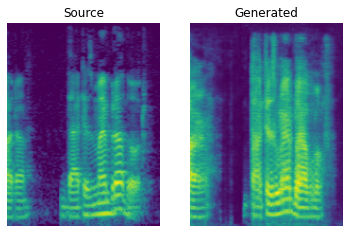

Mean D loss: 0.35983675718307495 Mean G loss: 0.6459983587265015 Mean ID loss: 0.08475975692272186
[Epoch 63/5000] [Batch 0] [D loss f: 0.3579275906085968 r: 0.4297912120819092] [G loss: 0.6638626456260681] [ID loss: 0.08481469005346298] [LR: 0.0002]
[Epoch 63/5000] [Batch 600] [D loss f: 0.3609546422958374 r: 0.43365955352783203] [G loss: 0.6620345711708069] [ID loss: 0.08484432101249695] [LR: 0.0002]
[Epoch 63/5000] [Batch 1200] [D loss f: 0.361698716878891 r: 0.4350954294204712] [G loss: 0.652644693851471] [ID loss: 0.08452808111906052] [LR: 0.0002]
[Epoch 63/5000] [Batch 1800] [D loss f: 0.35806435346603394 r: 0.4356983006000519] [G loss: 0.6407209038734436] [ID loss: 0.08503492921590805] [LR: 0.0002]
[Epoch 63/5000] [Batch 2400] [D loss f: 0.35419437289237976 r: 0.4331634044647217] [G loss: 0.64332515001297] [ID loss: 0.08479731529951096] [LR: 0.0002]
[Epoch 63/5000] [Batch 3000] [D loss f: 0.3598182797431946 r: 0.433296799659729] [G loss: 0.6441690325737] [ID loss: 0.084542728960

  2%|▏         | 30/2000 [00:00<00:04, 413.85it/s, loss=0.000546, spectral_convergence=-3.37]

Saving...
(6, 192, 24, 1)


 50%|█████     | 1000/2000 [00:01<00:01, 556.40it/s, loss=0.000258, spectral_convergence=-9.84]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[Epoch 66/5000] [Batch 6000] [D loss f: 0.3577583432197571 r: 0.4314119517803192] [G loss: 0.6296753883361816] [ID loss: 0.08488196134567261] [LR: 0.0002]
[Epoch 66/5000] [Batch 6600] [D loss f: 0.354885458946228 r: 0.43819868564605713] [G loss: 0.6579228639602661] [ID loss: 0.08421437442302704] [LR: 0.0002]
[Epoch 66/5000] [Batch 7200] [D loss f: 0.3590632677078247 r: 0.4316280484199524] [G loss: 0.6680611371994019] [ID loss: 0.08403292298316956] [LR: 0.0002]
[Epoch 66/5000] [Batch 7800] [D loss f: 0.36048680543899536 r: 0.43050485849380493] [G loss: 0.6534913778305054] [ID loss: 0.08469310402870178] [LR: 0.0002]
[Epoch 66/5000] [Batch 8400] [D loss f: 0.35853174328804016 r: 0.4328560531139374] [G loss: 0.6672490239143372] [ID loss: 0.0846237912774086] [LR: 0.0002]
[Epoch 66/5000] [Batch 9000] [D loss f: 0.3619813919067383 r: 0.4270316958427429] [G loss: 0.6412754654884338] [ID loss: 0.08475283533334732] [LR: 0.0002]
[Epoch 66/5000] [Batch 9600] [D loss f: 0.3595878481864929 r: 0.4363

  2%|▏         | 30/2000 [00:00<00:04, 414.64it/s, loss=0.000969, spectral_convergence=-2.86]

Saving...
(6, 192, 24, 1)


100%|██████████| 2000/2000 [00:03<00:00, 546.30it/s, loss=8.18e-5, spectral_convergence=-37.9] 


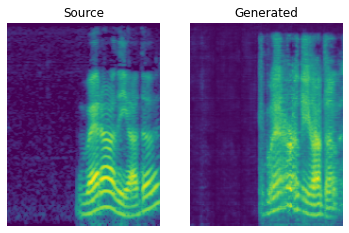

Mean D loss: 0.3578307330608368 Mean G loss: 0.6486920118331909 Mean ID loss: 0.08448901772499084
[Epoch 67/5000] [Batch 0] [D loss f: 0.35944926738739014 r: 0.43066203594207764] [G loss: 0.6284451484680176] [ID loss: 0.08446554839611053] [LR: 0.0002]
[Epoch 67/5000] [Batch 600] [D loss f: 0.35722869634628296 r: 0.4349707067012787] [G loss: 0.6478996872901917] [ID loss: 0.08434243500232697] [LR: 0.0002]
[Epoch 67/5000] [Batch 1200] [D loss f: 0.3570725619792938 r: 0.4322952926158905] [G loss: 0.6344616413116455] [ID loss: 0.08444226533174515] [LR: 0.0002]
[Epoch 67/5000] [Batch 1800] [D loss f: 0.3560141623020172 r: 0.4339696168899536] [G loss: 0.6450393795967102] [ID loss: 0.08428561687469482] [LR: 0.0002]
[Epoch 67/5000] [Batch 2400] [D loss f: 0.35530930757522583 r: 0.4372183084487915] [G loss: 0.645887553691864] [ID loss: 0.08426223695278168] [LR: 0.0002]
[Epoch 67/5000] [Batch 3000] [D loss f: 0.3611443042755127 r: 0.42651695013046265] [G loss: 0.6542158722877502] [ID loss: 0.0843

  2%|▏         | 30/2000 [00:00<00:04, 425.36it/s, loss=0.0002, spectral_convergence=-7.32]  

Saving...
(6, 192, 24, 1)


100%|██████████| 2000/2000 [00:03<00:00, 537.74it/s, loss=1.76e-5, spectral_convergence=-44.5]


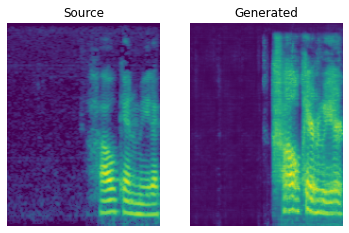

Mean D loss: 0.3576996624469757 Mean G loss: 0.655323326587677 Mean ID loss: 0.08440957963466644
[Epoch 69/5000] [Batch 0] [D loss f: 0.35937073826789856 r: 0.4315768778324127] [G loss: 0.6849562525749207] [ID loss: 0.08434131741523743] [LR: 0.0002]
[Epoch 69/5000] [Batch 600] [D loss f: 0.362874299287796 r: 0.43285563588142395] [G loss: 0.6414172649383545] [ID loss: 0.08428773283958435] [LR: 0.0002]
[Epoch 69/5000] [Batch 1200] [D loss f: 0.35690802335739136 r: 0.43631216883659363] [G loss: 0.646172285079956] [ID loss: 0.08429204672574997] [LR: 0.0002]
[Epoch 69/5000] [Batch 1800] [D loss f: 0.35385066270828247 r: 0.4387602210044861] [G loss: 0.6487706899642944] [ID loss: 0.08414016664028168] [LR: 0.0002]
[Epoch 69/5000] [Batch 2400] [D loss f: 0.35331231355667114 r: 0.4348808825016022] [G loss: 0.6587620377540588] [ID loss: 0.08436737209558487] [LR: 0.0002]
[Epoch 69/5000] [Batch 3000] [D loss f: 0.3549858629703522 r: 0.4370611011981964] [G loss: 0.6559813618659973] [ID loss: 0.08459

  1%|          | 20/2000 [00:00<00:05, 335.79it/s, loss=0.000215, spectral_convergence=-6.86]

Saving...
(6, 192, 24, 1)


100%|██████████| 2000/2000 [00:03<00:00, 521.20it/s, loss=2.01e-5, spectral_convergence=-38.9]


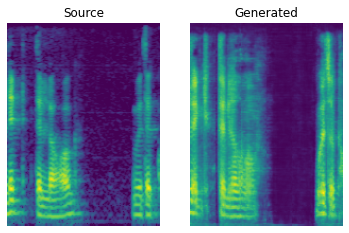

Mean D loss: 0.35587242245674133 Mean G loss: 0.6578332185745239 Mean ID loss: 0.0842076987028122
[Epoch 71/5000] [Batch 0] [D loss f: 0.3553432524204254 r: 0.4388004243373871] [G loss: 0.6868542432785034] [ID loss: 0.08450476080179214] [LR: 0.0002]
[Epoch 71/5000] [Batch 600] [D loss f: 0.3571414649486542 r: 0.43439412117004395] [G loss: 0.6307541131973267] [ID loss: 0.08420907706022263] [LR: 0.0002]
[Epoch 71/5000] [Batch 1200] [D loss f: 0.35301321744918823 r: 0.4404216408729553] [G loss: 0.6600525975227356] [ID loss: 0.08419108390808105] [LR: 0.0002]
[Epoch 71/5000] [Batch 1800] [D loss f: 0.3567814230918884 r: 0.44020140171051025] [G loss: 0.6476433277130127] [ID loss: 0.08394431322813034] [LR: 0.0002]
[Epoch 71/5000] [Batch 2400] [D loss f: 0.3488457500934601 r: 0.43545785546302795] [G loss: 0.6500890851020813] [ID loss: 0.08456148952245712] [LR: 0.0002]
[Epoch 71/5000] [Batch 3000] [D loss f: 0.3486727774143219 r: 0.44168177247047424] [G loss: 0.6439905166625977] [ID loss: 0.084

  2%|▏         | 30/2000 [00:00<00:04, 412.87it/s, loss=0.00141, spectral_convergence=-3.05]

Saving...
(6, 192, 24, 1)


100%|██████████| 2000/2000 [00:03<00:00, 530.65it/s, loss=6.81e-5, spectral_convergence=-31.5]


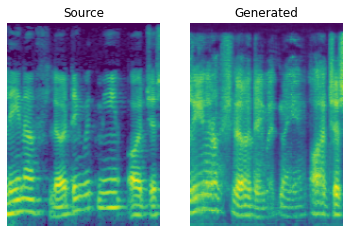

Mean D loss: 0.35678592324256897 Mean G loss: 0.6556364297866821 Mean ID loss: 0.08407843112945557
[Epoch 73/5000] [Batch 0] [D loss f: 0.3619295060634613 r: 0.43584582209587097] [G loss: 0.6438233852386475] [ID loss: 0.08431396633386612] [LR: 0.0002]
[Epoch 73/5000] [Batch 600] [D loss f: 0.3512793779373169 r: 0.4390650987625122] [G loss: 0.6591819524765015] [ID loss: 0.08399701118469238] [LR: 0.0002]
[Epoch 73/5000] [Batch 1200] [D loss f: 0.35940754413604736 r: 0.44066476821899414] [G loss: 0.6547083854675293] [ID loss: 0.08388406783342361] [LR: 0.0002]
[Epoch 73/5000] [Batch 1800] [D loss f: 0.35660189390182495 r: 0.4353937804698944] [G loss: 0.6290395855903625] [ID loss: 0.08431437611579895] [LR: 0.0002]
[Epoch 73/5000] [Batch 2400] [D loss f: 0.35261672735214233 r: 0.4426383078098297] [G loss: 0.6651399731636047] [ID loss: 0.08401911705732346] [LR: 0.0002]
[Epoch 73/5000] [Batch 3000] [D loss f: 0.34722062945365906 r: 0.43560466170310974] [G loss: 0.6434012651443481] [ID loss: 0.

  1%|          | 20/2000 [00:00<00:05, 340.42it/s, loss=0.00854, spectral_convergence=-.491]

Saving...
(6, 192, 24, 1)


100%|██████████| 2000/2000 [00:03<00:00, 521.46it/s, loss=4.87e-5, spectral_convergence=-35.2]


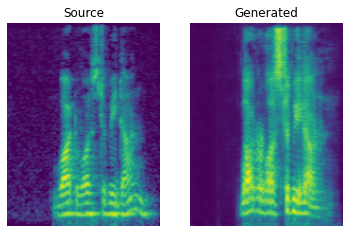

Mean D loss: 0.35381749272346497 Mean G loss: 0.6521767973899841 Mean ID loss: 0.08405492454767227
[Epoch 75/5000] [Batch 0] [D loss f: 0.3543904423713684 r: 0.4435373544692993] [G loss: 0.6752654314041138] [ID loss: 0.08395291864871979] [LR: 0.0002]
[Epoch 75/5000] [Batch 600] [D loss f: 0.35381653904914856 r: 0.4378909170627594] [G loss: 0.6876405477523804] [ID loss: 0.08367515355348587] [LR: 0.0002]
[Epoch 75/5000] [Batch 1200] [D loss f: 0.3543572723865509 r: 0.44012582302093506] [G loss: 0.6569781303405762] [ID loss: 0.08423099666833878] [LR: 0.0002]
[Epoch 75/5000] [Batch 1800] [D loss f: 0.35635489225387573 r: 0.43949463963508606] [G loss: 0.65311199426651] [ID loss: 0.0840676948428154] [LR: 0.0002]
[Epoch 75/5000] [Batch 2400] [D loss f: 0.35637354850769043 r: 0.43842875957489014] [G loss: 0.6674073934555054] [ID loss: 0.08394023776054382] [LR: 0.0002]
[Epoch 75/5000] [Batch 3000] [D loss f: 0.3576621115207672 r: 0.44028860330581665] [G loss: 0.619945228099823] [ID loss: 0.0844

  1%|          | 20/2000 [00:00<00:06, 322.06it/s, loss=0.000302, spectral_convergence=-4.41]

Saving...
(6, 192, 24, 1)


100%|██████████| 2000/2000 [00:03<00:00, 510.71it/s, loss=3.5e-5, spectral_convergence=-28.3] 


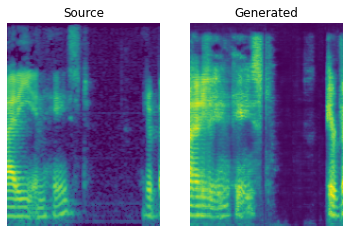

Mean D loss: 0.3533630967140198 Mean G loss: 0.6572913527488708 Mean ID loss: 0.08390049636363983
[Epoch 77/5000] [Batch 0] [D loss f: 0.35769280791282654 r: 0.4351310431957245] [G loss: 0.7023212909698486] [ID loss: 0.08419376611709595] [LR: 0.0002]
[Epoch 77/5000] [Batch 600] [D loss f: 0.3536653518676758 r: 0.4371841549873352] [G loss: 0.6426674127578735] [ID loss: 0.08404943346977234] [LR: 0.0002]
[Epoch 77/5000] [Batch 1200] [D loss f: 0.3524896204471588 r: 0.4422356188297272] [G loss: 0.66489577293396] [ID loss: 0.0836283415555954] [LR: 0.0002]
[Epoch 77/5000] [Batch 1800] [D loss f: 0.3501377999782562 r: 0.4386659860610962] [G loss: 0.6516146659851074] [ID loss: 0.08390912413597107] [LR: 0.0002]
[Epoch 77/5000] [Batch 2400] [D loss f: 0.3562789261341095 r: 0.44177988171577454] [G loss: 0.6551498174667358] [ID loss: 0.08371465653181076] [LR: 0.0002]
[Epoch 77/5000] [Batch 3000] [D loss f: 0.35059985518455505 r: 0.4397095739841461] [G loss: 0.6541226506233215] [ID loss: 0.08370590

  2%|▏         | 30/2000 [00:00<00:05, 381.34it/s, loss=0.000777, spectral_convergence=-4.93]

Saving...
(6, 192, 24, 1)


100%|██████████| 2000/2000 [00:03<00:00, 515.03it/s, loss=3.71e-5, spectral_convergence=-36.7]


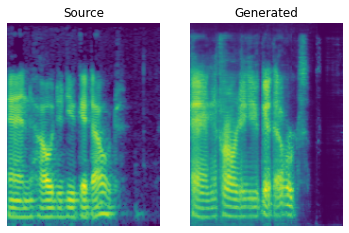

Mean D loss: 0.3521538972854614 Mean G loss: 0.656583845615387 Mean ID loss: 0.08377251774072647
[Epoch 79/5000] [Batch 0] [D loss f: 0.34718742966651917 r: 0.44377854466438293] [G loss: 0.6446202397346497] [ID loss: 0.08360153436660767] [LR: 0.0002]
[Epoch 79/5000] [Batch 600] [D loss f: 0.345879465341568 r: 0.4465391933917999] [G loss: 0.6406449675559998] [ID loss: 0.08349781483411789] [LR: 0.0002]
[Epoch 79/5000] [Batch 1200] [D loss f: 0.35558533668518066 r: 0.4407515525817871] [G loss: 0.6831192970275879] [ID loss: 0.08379387110471725] [LR: 0.0002]
[Epoch 79/5000] [Batch 1800] [D loss f: 0.34432899951934814 r: 0.4468175172805786] [G loss: 0.645387589931488] [ID loss: 0.08349473029375076] [LR: 0.0002]
[Epoch 79/5000] [Batch 2400] [D loss f: 0.3514728248119354 r: 0.4434899389743805] [G loss: 0.6531832814216614] [ID loss: 0.08360449224710464] [LR: 0.0002]
[Epoch 79/5000] [Batch 3000] [D loss f: 0.35231253504753113 r: 0.44297587871551514] [G loss: 0.678581953048706] [ID loss: 0.083657

In [ ]:
#Training

#n_save = how many epochs between each saving and displaying of results
#gupt = how many discriminator updates for generator+siamese update

train(epochs=5000, batch_size=bs, lr=0.0002, n_save=2, gupt=3, dsa=dsa, dsb=dsb, save_path=expr_dir)

In [ ]:
#After Training, use these functions to convert data with the generator and save the results

#Assembling generated Spectrogram chunks into final Spectrogram
def specass(a,spec):
  but=False
  con = np.array([])
  nim = a.shape[0]
  for i in range(nim-1):
    im = a[i]
    im = np.squeeze(im)
    if not but:
      con=im
      but=True
    else:
      con = np.concatenate((con,im), axis=1)
  diff = spec.shape[1]-(nim*shape)
  a = np.squeeze(a)
  con = np.concatenate((con,a[-1,:,-diff:]), axis=1)
  return np.squeeze(con)

#Splitting input spectrogram into different chunks to feed to the generator
def chopspec(spec):
  dsa=[]
  for i in range(spec.shape[1]//shape):
    im = spec[:,i*shape:i*shape+shape]
    im = np.reshape(im, (im.shape[0],im.shape[1],1))
    dsa.append(im)
  imlast = spec[:,-shape:]
  imlast = np.reshape(imlast, (imlast.shape[0],imlast.shape[1],1))
  dsa.append(imlast)
  return np.array(dsa, dtype=np.float32)

#Converting from source Spectrogram to target Spectrogram
def towave(spec, name, path='../content/', show=False):
  specarr = chopspec(spec)
  print(specarr.shape)
  a = specarr
  print('Generating...')
  ab = gen(a, training=False)
  print('Assembling and Converting...')
  a = specass(a,spec)
  ab = specass(ab,spec)
  awv = deprep(a)
  abwv = deprep(ab)
  print('Saving...')
  pathfin = f'{path}/{name}'
  os.mkdir(pathfin)
  sf.write(pathfin+'/AB.wav', abwv, sr)
  sf.write(pathfin+'/A.wav', awv, sr)
  print('Saved WAV!')
  IPython.display.display(IPython.display.Audio(np.squeeze(abwv), rate=sr))
  IPython.display.display(IPython.display.Audio(np.squeeze(awv), rate=sr))
  if show:
    fig, axs = plt.subplots(ncols=2)
    axs[0].imshow(np.flip(a, -2), cmap=None)
    axs[0].axis('off')
    axs[0].set_title('Source')
    axs[1].imshow(np.flip(ab, -2), cmap=None)
    axs[1].axis('off')
    axs[1].set_title('Generated')
    plt.show()
  return abwv

In [ ]:
# running inference

gen,critic,siam, [opt_gen,opt_disc] = get_networks(shape, load_model=True, path='/data/output/models/exp4/MELGANVC-0.4230792-0.6292385-0.0805247')

wv, sr = librosa.load('/data/wav/v1/india/common_voice_en_18882406.wav', sr=16000)  #Load waveform
print(wv.shape)
speca = prep(wv)                                                    #Waveform to Spectrogram

plt.figure(figsize=(50,1))                                          #Show Spectrogram
plt.imshow(np.flip(speca, axis=0), cmap=None)
plt.axis('off')
plt.show()

abwv = towave(speca, name='test7', path='.')           #Convert and save wav

In [ ]:
#Wav to wav conversion

wv, sr = librosa.load(librosa.util.example_audio_file(), sr=16000)  #Load waveform
print(wv.shape)
speca = prep(wv)                                                    #Waveform to Spectrogram

plt.figure(figsize=(50,1))                                          #Show Spectrogram
plt.imshow(np.flip(speca, axis=0), cmap=None)
plt.axis('off')
plt.show()

abwv = towave(speca, name='FILENAME1', path='./')           #Convert and save wav